In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.providers.aer import QasmSimulator
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from data_provider import load_titanic_pd
from utils import record_test_result_for_kaggle

In [5]:
df_train, df_test, y_train, _ = load_titanic_pd('train.csv', 'test.csv')

/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = numer_map[df[col][i]]
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:131: SettingWithCopyWarning

     Survived  Pclass Sex Age  SibSp  Parch  Fare Embarked
0           0       3   0   2      1      0     0        0
1           1       1   1   3      1      0     3        1
2           1       3   1   2      0      0     0        0
3           1       1   1   3      1      0     3        0
4           0       3   0   3      0      0     0        0
..        ...     ...  ..  ..    ...    ...   ...      ...
886         0       2   0   2      0      0     1        0
887         1       1   1   1      0      0     3        0
888         0       3   1   3      1      2     2        0
889         1       1   0   2      0      0     3        1
890         0       3   0   3      0      0     0        2

[891 rows x 8 columns]


In [3]:
for col in df_train.columns:
    print(f"{col}: unique {len(df_train[col].unique())}")

Pclass: unique 3
Sex: unique 2
Age: unique 8
SibSp: unique 7
Parch: unique 7
Fare: unique 4
Embarked: unique 4


In [6]:
# Age processing

df_train['Age'] = df_train.Age // 10
df_test['Age'] = df_test.Age // 10

In [7]:
def fare_map(x):
    if x < 10:
        return 0
    if x < 20:
        return 1
    if x < 30:
        return 2
    else:
        return 3
    
df_train['Fare'] = df_train['Fare'].apply(fare_map)
df_test['Fare'] = df_test['Fare'].apply(fare_map)

In [6]:
from quantum_utils import select_features
mvp_col = select_features(df_train, y_train, feat_num=4)

-----
Full features:
Final train score: 0.893378
Final F1 score: 0.854962
-----
Majority
Final train acc: 0.616162
Final train F1:0.000000
Feature rank based on importance
['Sex', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Embarked']
Selected features: Sex,Age,Pclass,Fare


In [7]:
df_train, df_test = df_train[mvp_col], df_test[mvp_col]

In [20]:
from sklearn import preprocessing

df_all = pd.concat([df_train, df_test])
# Encode to number
for col in df_train.columns:
    le = preprocessing.LabelEncoder().fit(df_all[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [21]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


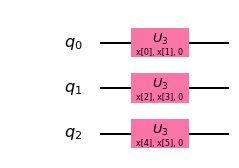

In [22]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(num_qubit, depth=4)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc 
feature_map.draw('mpl')

In [26]:
np.mean(y)

0.3838383838383838

In [33]:
from sklearn.model_selection import KFold

np.random.seed(123123)

kf = KFold(5, shuffle=True)

loss_logs_31 = []
results_31 = []
acc_f1s_train_31 = []
acc_f1s_test_31 = []

def one_and_1_3(x):
    return np.concatenate([x, x[:len(x)//3]], axis=0)

def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/titanic_QRAC_fold_{ro}')
    
    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_train)):
    
    
    df_train_q, y_train = data_train[train_idxs], y[train_idxs]
    df_test_q, y_test = data_train[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: one_and_1_3(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31.append(loss_log)
    results_31.append(result)
    acc_f1s_train_31.append(acc_f1_train)
    acc_f1s_test_31.append(acc_f1_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
2020-07-29 20:08:13,189:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimizatio

2020-07-29 20:11:22,876:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:26,026:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7506439285287106
2020-07-29 20:11:31,615:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:34,421:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7634878303454911
2020-07-29 20:11:40,146:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:43,343:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7070794866402286
2020-07-29 20:11:48,996:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:11:51,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.698366760183536
2020-07-29 20:11:57,642:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validati

2020-07-29 20:16:04,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.8670789
2020-07-29 20:16:10,261:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:16:13,103:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6922309778503686
2020-07-29 20:16:19,053:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:16:22,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6801840043593301
2020-07-29 20:16:22,299:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: 0.6922310
2020-07-29 20:16:22,299:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: 0.6801840
2020-07-29 20:16:28,254:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:16:31,076:qiskit.aqua.algorithms.classifiers

2020-07-29 20:19:36,994:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5448556303689489
2020-07-29 20:19:36,994:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.5399190
2020-07-29 20:19:36,995:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 13: 0.5448556
2020-07-29 20:19:43,153:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:19:46,041:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5490548991929767
2020-07-29 20:19:51,934:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:19:55,077:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5354285160042799
2020-07-29 20:19:55,078:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 14: 0.5490549
2020-07-29 20:19:55,079:qiskit.aqua.components.optimizer

2020-07-29 20:23:02,759:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5333329360008562
2020-07-29 20:23:08,614:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:23:11,804:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5257973659798746
2020-07-29 20:23:11,805:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 25: 0.5333329
2020-07-29 20:23:11,806:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 25: 0.5257974
2020-07-29 20:23:17,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:23:20,730:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5322091271843027
2020-07-29 20:23:26,540:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:23:29,436:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 20:26:27,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.5265407
2020-07-29 20:26:33,897:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:26:37,039:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5218058740315783
2020-07-29 20:26:42,919:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:26:45,837:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5225301075851386
2020-07-29 20:26:45,838:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 37: 0.5218059
2020-07-29 20:26:45,839:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 37: 0.5225301
2020-07-29 20:26:51,582:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:26:54,715:qiskit.aqua.algorithms.classifi

2020-07-29 20:31:32,366:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5204308
2020-07-29 20:31:32,367:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.5170059
2020-07-29 20:31:38,269:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:31:41,377:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163665681987082
2020-07-29 20:31:47,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:31:50,230:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5199235903256361
2020-07-29 20:31:50,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 54: 0.5163666
2020-07-29 20:31:50,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 54: 0.5199236
2020-07-29 20:31:55,919:qiskit.aqua.utils.run_

2020-07-29 20:35:04,274:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:35:07,094:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5255638667393806
2020-07-29 20:35:07,095:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: 0.5246888
2020-07-29 20:35:07,096:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: 0.5255639
2020-07-29 20:35:12,946:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:35:16,179:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5214937836580172
2020-07-29 20:35:21,799:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:35:24,838:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5203000798074917
2020-07-29 20:35:24,839:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 20:38:30,487:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:38:33,599:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5160606958779762
2020-07-29 20:38:39,510:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:38:42,765:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5157839579489177
2020-07-29 20:38:42,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 0.5160607
2020-07-29 20:38:42,767:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 0.5157840
2020-07-29 20:38:48,511:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:38:51,390:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5146362045671292
2020-07-29 20:38:57,645:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 20:41:58,984:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5193789
2020-07-29 20:41:58,985:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.5164540
2020-07-29 20:42:04,875:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:42:07,999:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5160506258216856
2020-07-29 20:42:13,704:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:42:16,909:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5172961395081365
2020-07-29 20:42:16,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 89: 0.5160506
2020-07-29 20:42:16,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 89: 0.5172961
2020-07-29 20:42:22,782:qiskit.aqua.utils.run_

2020-07-29 20:45:30,983:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:45:33,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5144335705693438
2020-07-29 20:45:33,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: 0.5162571
2020-07-29 20:45:33,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: 0.5144336
2020-07-29 20:45:39,687:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:45:42,779:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124397550989777
2020-07-29 20:45:48,628:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:45:51,785:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122258864564059
2020-07-29 20:45:51,786:qiskit.aqua.components.optimizers.spsa:

2020-07-29 20:48:56,362:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:48:59,470:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5133741852487193
2020-07-29 20:49:05,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:49:08,308:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5131801968386637
2020-07-29 20:49:08,309:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 0.5133742
2020-07-29 20:49:08,310:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 0.5131802
2020-07-29 20:49:14,227:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:49:17,044:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5174556402739342
2020-07-29 20:49:23,215:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 20:52:24,880:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5121227
2020-07-29 20:52:24,880:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.5132265
2020-07-29 20:52:30,738:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:52:33,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5128793737863652
2020-07-29 20:52:39,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:52:42,740:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5080537144322781
2020-07-29 20:52:42,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 124: 0.5128794
2020-07-29 20:52:42,741:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 124: 0.5080537
2020-07-29 20:52:48,531:qiskit.aqua.utils.

2020-07-29 20:55:56,732:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:55:59,618:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5147386182229694
2020-07-29 20:55:59,619:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: 0.5141956
2020-07-29 20:55:59,620:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: 0.5147386
2020-07-29 20:56:05,682:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:56:08,847:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5145315879860689
2020-07-29 20:56:14,531:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:56:17,663:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5139471421987012
2020-07-29 20:56:17,664:qiskit.aqua.components.optimizers.spsa:

2020-07-29 20:59:22,614:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:59:25,760:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5095057737688892
2020-07-29 20:59:31,436:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:59:34,595:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124317844755284
2020-07-29 20:59:34,596:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 0.5095058
2020-07-29 20:59:34,597:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 147: 0.5124318
2020-07-29 20:59:40,411:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 20:59:43,199:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5094994352485278
2020-07-29 20:59:49,351:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 21:02:50,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5134799
2020-07-29 21:02:50,834:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.5113312
2020-07-29 21:02:56,790:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:02:59,965:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5080877567739848
2020-07-29 21:03:05,713:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:03:08,841:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5111246154289939
2020-07-29 21:03:08,841:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 159: 0.5080878
2020-07-29 21:03:08,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 159: 0.5111246
2020-07-29 21:03:14,890:qiskit.aqua.utils.

2020-07-29 21:06:23,407:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:06:26,251:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5089807163645395
2020-07-29 21:06:26,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: 0.5135338
2020-07-29 21:06:26,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: 0.5089807
2020-07-29 21:06:31,995:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:06:35,092:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5089495544695959
2020-07-29 21:06:40,868:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:06:44,031:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5111014423819672
2020-07-29 21:06:44,032:qiskit.aqua.components.optimizers.spsa:

2020-07-29 21:09:48,401:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:09:51,588:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124708687764216
2020-07-29 21:09:57,517:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:10:00,327:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5140076719706175
2020-07-29 21:10:00,327:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 182: 0.5124709
2020-07-29 21:10:00,328:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 182: 0.5140077
2020-07-29 21:10:06,309:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:10:09,438:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5099217185204017
2020-07-29 21:10:15,124:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 21:13:17,303:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5079910
2020-07-29 21:13:17,304:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.5086132
2020-07-29 21:13:23,556:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:13:26,419:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5108601872006796
2020-07-29 21:13:32,484:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:13:35,296:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5120809779279811
2020-07-29 21:13:35,297:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 194: 0.5108602
2020-07-29 21:13:35,297:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 194: 0.5120810
2020-07-29 21:13:41,225:qiskit.aqua.utils.

2020-07-29 21:15:24,009:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 21:15:24,010:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 21:15:24,011:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 21:15:30,016:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:15:33,231:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9608104865881432
2020-07-29 21:15:39,128:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:15:42,285:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9614381170240296
2020-07-29 21:15:48,164:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:15:50,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.025158331

2020-07-29 21:20:28,139:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9451620788604532
2020-07-29 21:20:34,032:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:20:37,283:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9907461177635056
2020-07-29 21:20:43,304:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:20:46,109:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9491027979205748
2020-07-29 21:20:52,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:20:55,237:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9249914043033617
2020-07-29 21:21:00,995:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:21:04,143:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 21:24:44,854:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:24:47,679:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6617303555458851
2020-07-29 21:24:54,095:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:24:56,917:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6452355042962692
2020-07-29 21:24:56,918:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6617304
2020-07-29 21:24:56,919:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6452355
2020-07-29 21:25:02,830:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:25:06,029:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6699323392823935
2020-07-29 21:25:11,840:qiskit.aqua.utils.run_circuits:INFO: Can't 

2020-07-29 21:28:14,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.5860239
2020-07-29 21:28:14,204:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6053478
2020-07-29 21:28:20,578:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:28:23,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5908989791204687
2020-07-29 21:28:29,568:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:28:32,423:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5980888561435722
2020-07-29 21:28:32,424:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.5908990
2020-07-29 21:28:32,425:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 18: 0.5980889
2020-07-29 21:28:38,513:qiskit.aqua.utils.run_

2020-07-29 21:31:46,429:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:31:49,204:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5718161679043925
2020-07-29 21:31:49,205:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5839260
2020-07-29 21:31:49,205:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5718162
2020-07-29 21:31:54,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:31:57,721:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.568811021872942
2020-07-29 21:32:03,872:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:32:06,687:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5746698487016051
2020-07-29 21:32:06,688:qiskit.aqua.components.optimizers.spsa:DEB

2020-07-29 21:35:11,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:35:14,564:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5584374510786136
2020-07-29 21:35:20,193:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:35:23,376:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5594500305794405
2020-07-29 21:35:23,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5584375
2020-07-29 21:35:23,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5594500
2020-07-29 21:35:29,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:35:32,164:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5594402584523023
2020-07-29 21:35:37,898:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 21:38:36,109:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5592868
2020-07-29 21:38:36,110:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5398296
2020-07-29 21:38:41,748:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:38:44,536:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5476895269635615
2020-07-29 21:38:50,474:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:38:53,612:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5399373894482224
2020-07-29 21:38:53,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5476895
2020-07-29 21:38:53,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.5399374
2020-07-29 21:38:59,358:qiskit.aqua.utils.run_

2020-07-29 21:42:07,409:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:42:10,253:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5406431630027752
2020-07-29 21:42:10,254:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5386888
2020-07-29 21:42:10,255:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5406432
2020-07-29 21:42:16,760:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:42:19,535:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5390225874360305
2020-07-29 21:42:25,422:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:42:28,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5443890741052185
2020-07-29 21:42:28,559:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 21:45:34,914:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:45:37,798:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5458022036567111
2020-07-29 21:45:43,497:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:45:46,620:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5385948158148457
2020-07-29 21:45:46,621:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5458022
2020-07-29 21:45:46,621:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5385948
2020-07-29 21:45:52,339:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:45:55,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.538504241851487
2020-07-29 21:46:01,434:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-07-29 21:49:04,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5397591
2020-07-29 21:49:04,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5409748
2020-07-29 21:49:10,421:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:49:13,232:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5335266771815277
2020-07-29 21:49:19,270:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:49:22,506:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5399783270514599
2020-07-29 21:49:22,506:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5335267
2020-07-29 21:49:22,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.5399783
2020-07-29 21:49:28,586:qiskit.aqua.utils.run_

2020-07-29 21:52:35,661:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:52:38,793:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5330905300360016
2020-07-29 21:52:38,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5363119
2020-07-29 21:52:38,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5330905
2020-07-29 21:52:44,594:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:52:47,764:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5308793454623981
2020-07-29 21:52:53,398:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:52:56,221:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5362915891192217
2020-07-29 21:52:56,222:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 21:56:00,095:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:56:03,217:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5353687154777976
2020-07-29 21:56:08,953:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:56:11,813:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5336356689454377
2020-07-29 21:56:11,813:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5353687
2020-07-29 21:56:11,814:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5336357
2020-07-29 21:56:18,195:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:56:21,055:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5347509063647977
2020-07-29 21:56:27,160:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 21:59:29,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5345715
2020-07-29 21:59:29,797:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5333825
2020-07-29 21:59:35,463:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:59:38,618:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5347804814332202
2020-07-29 21:59:44,359:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 21:59:47,220:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5340978130848986
2020-07-29 21:59:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5347805
2020-07-29 21:59:47,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.5340978
2020-07-29 21:59:53,391:qiskit.aqua.utils.

2020-07-29 22:03:01,416:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:03:04,616:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5313457871556689
2020-07-29 22:03:04,617:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5291370
2020-07-29 22:03:04,618:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5313458
2020-07-29 22:03:10,629:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:03:13,478:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5341717591757371
2020-07-29 22:03:19,610:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:03:22,761:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.529132143733464
2020-07-29 22:03:22,762:qiskit.aqua.components.optimizers.spsa:D

2020-07-29 22:06:28,013:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:06:30,802:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5303056729617152
2020-07-29 22:06:36,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:06:39,766:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5284501156975595
2020-07-29 22:06:39,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5303057
2020-07-29 22:06:39,767:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5284501
2020-07-29 22:06:45,582:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:06:48,748:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280647627659932
2020-07-29 22:06:54,666:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 22:09:57,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5322920
2020-07-29 22:09:57,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5282985
2020-07-29 22:10:03,581:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:10:06,398:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5267431080719456
2020-07-29 22:10:12,406:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:10:15,575:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5314317904449843
2020-07-29 22:10:15,576:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5267431
2020-07-29 22:10:15,577:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.5314318
2020-07-29 22:10:21,767:qiskit.aqua.utils.

2020-07-29 22:13:30,045:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:13:32,880:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5282616721109817
2020-07-29 22:13:32,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5304723
2020-07-29 22:13:32,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5282617
2020-07-29 22:13:39,140:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:13:42,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5274289005370632
2020-07-29 22:13:48,033:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:13:50,946:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5279844596748324
2020-07-29 22:13:50,947:qiskit.aqua.components.optimizers.spsa:

2020-07-29 22:16:56,440:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:16:59,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5266690210297786
2020-07-29 22:17:05,315:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:17:08,192:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280533866567372
2020-07-29 22:17:08,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5266690
2020-07-29 22:17:08,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5280534
2020-07-29 22:17:14,273:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:17:17,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5269136952666497
2020-07-29 22:17:23,435:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 22:20:25,471:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5272329
2020-07-29 22:20:25,472:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5246226
2020-07-29 22:20:31,890:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:20:34,715:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.526051173797041
2020-07-29 22:20:40,889:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:20:43,737:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5294853442917271
2020-07-29 22:20:43,738:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5260512
2020-07-29 22:20:43,739:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.5294853
2020-07-29 22:20:50,045:qiskit.aqua.utils.r

2020-07-29 22:22:50,074:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-29 22:22:50,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 22:22:50,075:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 22:22:50,075:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 22:22:55,943:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:22:59,089:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9016290017365657
2020-07-29 22:23:05,139:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:23:08,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8598618394062081
2020-07-29 22:23:14,090:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-29 22:27:50,250:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:27:53,389:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9252039588863793
2020-07-29 22:27:59,163:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:28:02,281:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8999102244169512
2020-07-29 22:28:08,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:28:11,034:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8650840055074849
2020-07-29 22:28:17,144:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:28:19,904:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8589922769941774
2020-07-29 22:28:25,744:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-07-29 22:32:03,009:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6998734
2020-07-29 22:32:09,232:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:32:12,072:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6814053007253875
2020-07-29 22:32:18,223:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:32:21,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7067516720010688
2020-07-29 22:32:21,051:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6814053
2020-07-29 22:32:21,052:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.7067517
2020-07-29 22:32:26,919:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:32:30,032:qiskit.aqua.algorithms.classifiers

2020-07-29 22:35:37,455:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6255163564895236
2020-07-29 22:35:37,456:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6777034
2020-07-29 22:35:37,457:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6255164
2020-07-29 22:35:43,295:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:35:46,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6268193819341603
2020-07-29 22:35:52,512:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:35:55,363:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6554674650428985
2020-07-29 22:35:55,363:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6268194
2020-07-29 22:35:55,364:qiskit.aqua.components.optimizer

2020-07-29 22:39:03,131:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5799366895862128
2020-07-29 22:39:09,088:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:39:11,910:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5706495666075853
2020-07-29 22:39:11,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5799367
2020-07-29 22:39:11,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5706496
2020-07-29 22:39:18,091:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:39:20,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5639332690610039
2020-07-29 22:39:27,150:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:39:29,955:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 22:42:29,895:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5428874
2020-07-29 22:42:35,773:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:42:38,973:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5385560057407146
2020-07-29 22:42:44,927:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:42:47,815:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5557269939922832
2020-07-29 22:42:47,816:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5385560
2020-07-29 22:42:47,817:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5557270
2020-07-29 22:42:54,144:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:42:57,033:qiskit.aqua.algorithms.classifi

2020-07-29 22:46:05,275:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5311986929681203
2020-07-29 22:46:05,276:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5291500
2020-07-29 22:46:05,276:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5311987
2020-07-29 22:46:11,609:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:46:14,430:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5208226548899513
2020-07-29 22:46:20,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:46:23,536:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5420006274936443
2020-07-29 22:46:23,537:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5208227
2020-07-29 22:46:23,538:qiskit.aqua.components.optimizer

2020-07-29 22:49:30,506:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5130105924999712
2020-07-29 22:49:36,240:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:49:39,425:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5144763195571033
2020-07-29 22:49:39,426:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5130106
2020-07-29 22:49:39,427:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5144763
2020-07-29 22:49:45,238:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:49:48,368:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5128339896964202
2020-07-29 22:49:54,073:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:49:56,880:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 22:52:56,005:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5094827
2020-07-29 22:53:01,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:53:04,700:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5107497288239143
2020-07-29 22:53:11,002:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:53:13,832:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5055459622457191
2020-07-29 22:53:13,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5107497
2020-07-29 22:53:13,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5055460
2020-07-29 22:53:19,736:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:53:22,878:qiskit.aqua.algorithms.classifi

2020-07-29 22:56:31,388:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5051593128165157
2020-07-29 22:56:31,389:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5105913
2020-07-29 22:56:31,390:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5051593
2020-07-29 22:56:37,078:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:56:39,889:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5103312081310462
2020-07-29 22:56:46,229:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 22:56:49,061:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5060469415662326
2020-07-29 22:56:49,062:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5103312
2020-07-29 22:56:49,062:qiskit.aqua.components.optimizer

2020-07-29 22:59:56,955:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.507017700207499
2020-07-29 23:00:03,113:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:00:05,954:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5050010155644562
2020-07-29 23:00:05,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5070177
2020-07-29 23:00:05,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5050010
2020-07-29 23:00:11,922:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:00:15,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5041993870431162
2020-07-29 23:00:20,788:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:00:23,648:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-29 23:03:22,717:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5003446
2020-07-29 23:03:28,488:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:03:31,625:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.503942383414438
2020-07-29 23:03:37,173:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:03:40,283:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5001445016106825
2020-07-29 23:03:40,284:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5039424
2020-07-29 23:03:40,285:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5001445
2020-07-29 23:03:46,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:03:48,926:qiskit.aqua.algorithms.classi

2020-07-29 23:06:56,952:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5063174884163905
2020-07-29 23:06:56,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5003100
2020-07-29 23:06:56,953:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5063175
2020-07-29 23:07:03,178:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:07:05,993:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5034290033900064
2020-07-29 23:07:11,863:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:07:15,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5014429367678791
2020-07-29 23:07:15,063:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5034290
2020-07-29 23:07:15,063:qiskit.aqua.components.optimi

2020-07-29 23:10:23,392:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4999040396775824
2020-07-29 23:10:29,134:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:10:32,232:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4981626889895611
2020-07-29 23:10:32,233:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.4999040
2020-07-29 23:10:32,233:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.4981627
2020-07-29 23:10:38,063:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:10:40,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5008571772573003
2020-07-29 23:10:47,134:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:10:49,945:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 23:13:49,579:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.4983877
2020-07-29 23:13:55,495:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:13:58,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5016915255265034
2020-07-29 23:14:04,432:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:14:07,235:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5049087537149984
2020-07-29 23:14:07,236:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5016915
2020-07-29 23:14:07,236:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5049088
2020-07-29 23:14:13,338:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:14:16,191:qiskit.aqua.algorithms.class

2020-07-29 23:17:22,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5006084150910906
2020-07-29 23:17:22,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.4978678
2020-07-29 23:17:22,552:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5006084
2020-07-29 23:17:28,541:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:17:31,354:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5027807511997987
2020-07-29 23:17:37,334:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:17:40,504:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4999979813112152
2020-07-29 23:17:40,505:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5027808
2020-07-29 23:17:40,506:qiskit.aqua.components.optimi

2020-07-29 23:20:48,768:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4972288717617881
2020-07-29 23:20:54,401:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:20:57,506:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4967692809001689
2020-07-29 23:20:57,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.4972289
2020-07-29 23:20:57,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.4967693
2020-07-29 23:21:03,381:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:21:06,498:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5036288827497867
2020-07-29 23:21:12,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:21:15,117:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 23:24:13,406:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5010864
2020-07-29 23:24:19,288:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:24:22,395:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49797808623457634
2020-07-29 23:24:28,261:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:24:31,055:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4965893858777975
2020-07-29 23:24:31,056:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.4979781
2020-07-29 23:24:31,057:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.4965894
2020-07-29 23:24:37,163:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:24:40,345:qiskit.aqua.algorithms.clas

2020-07-29 23:27:47,186:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5020220162185901
2020-07-29 23:27:47,187:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.4962681
2020-07-29 23:27:47,187:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5020220
2020-07-29 23:27:53,065:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:27:56,252:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4967687127687267
2020-07-29 23:28:02,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:28:05,007:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4965094828416956
2020-07-29 23:28:05,008:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.4967687
2020-07-29 23:28:05,009:qiskit.aqua.components.optimi

2020-07-29 23:30:11,612:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-29 23:30:11,612:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 23:30:11,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 23:30:11,614:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 23:30:17,476:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:30:20,317:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7869454847620436
2020-07-29 23:30:26,241:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:30:29,424:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.822700098218663
2020-07-29 23:30:35,569:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation 

2020-07-29 23:35:11,821:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:14,743:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8633686846045504
2020-07-29 23:35:21,080:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:23,974:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7945669958360198
2020-07-29 23:35:30,055:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:32,940:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7860118317597334
2020-07-29 23:35:39,065:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:35:41,988:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.846487864186816
2020-07-29 23:35:47,845:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validati

2020-07-29 23:39:26,547:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6608656
2020-07-29 23:39:32,661:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:39:35,841:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6191723596946601
2020-07-29 23:39:41,584:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:39:44,407:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6529673782717156
2020-07-29 23:39:44,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6191724
2020-07-29 23:39:44,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6529674
2020-07-29 23:39:50,408:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:39:53,247:qiskit.aqua.algorithms.classifiers

2020-07-29 23:43:02,679:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6023041840449501
2020-07-29 23:43:02,680:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6168395
2020-07-29 23:43:02,681:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6023042
2020-07-29 23:43:08,464:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:43:11,667:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6173635323172774
2020-07-29 23:43:17,644:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:43:20,573:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.59585173377385
2020-07-29 23:43:20,574:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6173635
2020-07-29 23:43:20,575:qiskit.aqua.components.optimizers.

2020-07-29 23:46:28,898:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5811878210828769
2020-07-29 23:46:35,021:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:46:37,850:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5545966210891671
2020-07-29 23:46:37,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5811878
2020-07-29 23:46:37,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5545966
2020-07-29 23:46:44,078:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:46:46,912:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.579132623988731
2020-07-29 23:46:52,924:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:46:56,095:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-29 23:49:56,749:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5388902
2020-07-29 23:50:02,457:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:50:05,518:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5368141619414054
2020-07-29 23:50:11,058:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:50:14,088:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5435396459313312
2020-07-29 23:50:14,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5368142
2020-07-29 23:50:14,089:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5435396
2020-07-29 23:50:20,046:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:50:22,836:qiskit.aqua.algorithms.classifi

2020-07-29 23:53:31,129:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5238036303987716
2020-07-29 23:53:31,130:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5379733
2020-07-29 23:53:31,130:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5238036
2020-07-29 23:53:36,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:53:40,093:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5311991135387027
2020-07-29 23:53:46,040:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:53:48,788:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5302421134572937
2020-07-29 23:53:48,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5311991
2020-07-29 23:53:48,790:qiskit.aqua.components.optimizer

2020-07-29 23:56:59,143:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5251397269761443
2020-07-29 23:57:05,219:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:57:08,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5294384772405141
2020-07-29 23:57:08,063:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5251397
2020-07-29 23:57:08,064:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5294385
2020-07-29 23:57:14,285:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:57:17,100:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5237017120449721
2020-07-29 23:57:23,028:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 23:57:26,139:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-30 00:00:26,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5232533
2020-07-30 00:00:32,487:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:00:35,655:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5242747395277458
2020-07-30 00:00:41,497:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:00:44,735:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5224107795423102
2020-07-30 00:00:44,736:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5242747
2020-07-30 00:00:44,737:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5224108
2020-07-30 00:00:50,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:00:53,459:qiskit.aqua.algorithms.classifi

2020-07-30 00:04:03,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5266892419362635
2020-07-30 00:04:03,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5190737
2020-07-30 00:04:03,552:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5266892
2020-07-30 00:04:09,721:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:04:12,594:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5203127256306811
2020-07-30 00:04:19,041:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:04:21,920:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.522783812587711
2020-07-30 00:04:21,920:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5203127
2020-07-30 00:04:21,921:qiskit.aqua.components.optimizers

2020-07-30 00:07:30,755:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5217688272423996
2020-07-30 00:07:36,707:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:07:39,573:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5214470666239613
2020-07-30 00:07:39,574:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5217688
2020-07-30 00:07:39,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5214471
2020-07-30 00:07:45,916:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:07:48,756:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.520314686757194
2020-07-30 00:07:54,681:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:07:57,809:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-30 00:10:58,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5230661
2020-07-30 00:11:04,887:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:11:07,999:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5202482958764962
2020-07-30 00:11:13,881:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:11:16,772:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5185094780627
2020-07-30 00:11:16,773:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5202483
2020-07-30 00:11:16,774:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5185095
2020-07-30 00:11:22,943:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:11:25,778:qiskit.aqua.algorithms.classifi

2020-07-30 00:14:33,032:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5153149142045914
2020-07-30 00:14:33,034:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5188236
2020-07-30 00:14:33,036:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5153149
2020-07-30 00:14:39,517:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:14:42,260:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163486788755144
2020-07-30 00:14:48,288:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:14:51,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5190033627979204
2020-07-30 00:14:51,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5163487
2020-07-30 00:14:51,350:qiskit.aqua.components.optimi

2020-07-30 00:18:00,762:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5175277175107366
2020-07-30 00:18:06,720:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:18:09,851:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5161050769966448
2020-07-30 00:18:09,852:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5175277
2020-07-30 00:18:09,853:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5161051
2020-07-30 00:18:15,763:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:18:18,668:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5190943239936675
2020-07-30 00:18:24,913:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:18:27,743:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-30 00:21:27,644:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.5171974
2020-07-30 00:21:33,426:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:21:36,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5187776668906007
2020-07-30 00:21:42,455:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:21:45,276:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5202724889966944
2020-07-30 00:21:45,277:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5187777
2020-07-30 00:21:45,278:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5202725
2020-07-30 00:21:51,062:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:21:54,195:qiskit.aqua.algorithms.class

2020-07-30 00:25:00,970:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5161931280779746
2020-07-30 00:25:00,970:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5175935
2020-07-30 00:25:00,971:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5161931
2020-07-30 00:25:07,399:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:25:10,137:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.516412714188202
2020-07-30 00:25:15,878:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:25:19,014:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165747495457416
2020-07-30 00:25:19,015:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5164127
2020-07-30 00:25:19,015:qiskit.aqua.components.optimiz

2020-07-30 00:28:28,433:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5154058647408695
2020-07-30 00:28:34,120:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:28:36,990:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5167206368264651
2020-07-30 00:28:36,991:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5154059
2020-07-30 00:28:36,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5167206
2020-07-30 00:28:43,416:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:28:46,287:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5151545480757227
2020-07-30 00:28:52,333:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:28:55,486:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-30 00:31:54,115:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5153412
2020-07-30 00:32:00,271:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:32:03,104:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5129597712247064
2020-07-30 00:32:09,281:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:32:12,178:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5146351060759197
2020-07-30 00:32:12,179:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5129598
2020-07-30 00:32:12,179:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5146351
2020-07-30 00:32:18,591:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:32:21,433:qiskit.aqua.algorithms.class

2020-07-30 00:35:30,013:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5183887379286496
2020-07-30 00:35:30,014:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5177878
2020-07-30 00:35:30,014:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5183887
2020-07-30 00:35:35,851:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:35:39,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5195476211515592
2020-07-30 00:35:44,853:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:35:47,991:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5125807866671408
2020-07-30 00:35:47,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5195476
2020-07-30 00:35:47,993:qiskit.aqua.components.optimi

2020-07-30 00:37:55,954:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-30 00:37:55,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-30 00:37:55,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-30 00:37:55,956:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-30 00:38:02,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:38:05,030:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7352624108438994
2020-07-30 00:38:11,364:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:38:14,199:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7493717932223696
2020-07-30 00:38:20,587:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-30 00:42:58,639:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:01,446:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7590102457907897
2020-07-30 00:43:07,639:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:10,559:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7502518701539491
2020-07-30 00:43:16,364:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:19,580:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7099351730174166
2020-07-30 00:43:25,503:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:43:28,651:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7523740027338033
2020-07-30 00:43:34,532:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-07-30 00:47:12,149:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6749856
2020-07-30 00:47:18,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:47:21,254:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6947523675598059
2020-07-30 00:47:27,272:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:47:30,084:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6704189124116201
2020-07-30 00:47:30,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6947524
2020-07-30 00:47:30,086:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6704189
2020-07-30 00:47:35,871:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:47:39,079:qiskit.aqua.algorithms.classifiers

2020-07-30 00:50:47,734:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.627709037301111
2020-07-30 00:50:47,735:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.5770686
2020-07-30 00:50:47,736:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6277090
2020-07-30 00:50:53,547:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:50:56,698:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5743979712414357
2020-07-30 00:51:02,461:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:51:05,611:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5607609077194461
2020-07-30 00:51:05,612:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.5743980
2020-07-30 00:51:05,613:qiskit.aqua.components.optimizers

2020-07-30 00:54:15,310:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5561342971516255
2020-07-30 00:54:21,249:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:54:24,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5528464574510814
2020-07-30 00:54:24,271:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5561343
2020-07-30 00:54:24,271:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5528465
2020-07-30 00:54:30,147:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:54:33,269:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5547118495652787
2020-07-30 00:54:39,369:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:54:42,223:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-30 00:57:41,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5451165
2020-07-30 00:57:47,498:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:57:50,370:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5438787443740153
2020-07-30 00:57:56,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:57:58,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5455758050732742
2020-07-30 00:57:58,936:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5438787
2020-07-30 00:57:58,936:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5455758
2020-07-30 00:58:05,003:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 00:58:07,888:qiskit.aqua.algorithms.classifi

2020-07-30 01:01:16,436:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5437427286609727
2020-07-30 01:01:16,437:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5366913
2020-07-30 01:01:16,438:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5437427
2020-07-30 01:01:22,233:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:01:25,379:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5351078152753764
2020-07-30 01:01:31,169:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:01:34,047:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5441467557837478
2020-07-30 01:01:34,048:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5351078
2020-07-30 01:01:34,048:qiskit.aqua.components.optimizer

2020-07-30 01:04:43,005:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5301835870227288
2020-07-30 01:04:48,639:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:04:51,797:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5283191820348134
2020-07-30 01:04:51,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5301836
2020-07-30 01:04:51,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.5283192
2020-07-30 01:04:57,635:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:05:00,533:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5291741455434608
2020-07-30 01:05:06,807:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:05:09,692:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-30 01:08:09,584:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5339364
2020-07-30 01:08:15,739:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:08:18,623:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.527716975566798
2020-07-30 01:08:24,689:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:08:27,577:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5293415856937372
2020-07-30 01:08:27,578:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5277170
2020-07-30 01:08:27,579:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5293416
2020-07-30 01:08:33,444:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:08:36,639:qiskit.aqua.algorithms.classifie

2020-07-30 01:11:45,628:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5235090771555853
2020-07-30 01:11:45,629:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5279499
2020-07-30 01:11:45,630:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5235091
2020-07-30 01:11:51,610:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:11:54,801:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5224410435870327
2020-07-30 01:12:00,751:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:12:03,996:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280723514166331
2020-07-30 01:12:03,997:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5224410
2020-07-30 01:12:03,997:qiskit.aqua.components.optimizer

2020-07-30 01:15:12,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.524103279683728
2020-07-30 01:15:17,666:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:15:20,800:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5193357868582876
2020-07-30 01:15:20,801:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5241033
2020-07-30 01:15:20,802:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5193358
2020-07-30 01:15:26,719:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:15:29,631:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5226418213367192
2020-07-30 01:15:35,780:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:15:38,655:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-30 01:18:38,112:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5198158
2020-07-30 01:18:44,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:18:47,078:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5268484317331628
2020-07-30 01:18:53,088:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:18:55,896:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5187251770760831
2020-07-30 01:18:55,897:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5268484
2020-07-30 01:18:55,898:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5187252
2020-07-30 01:19:01,632:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:19:04,803:qiskit.aqua.algorithms.class

2020-07-30 01:22:13,068:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5179741403244269
2020-07-30 01:22:13,069:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5215391
2020-07-30 01:22:13,070:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5179741
2020-07-30 01:22:19,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:22:21,942:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5192324125686766
2020-07-30 01:22:27,964:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:22:30,847:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.519888203388812
2020-07-30 01:22:30,848:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5192324
2020-07-30 01:22:30,849:qiskit.aqua.components.optimiz

2020-07-30 01:25:39,004:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.517848196905002
2020-07-30 01:25:45,020:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:25:47,868:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5193574230427318
2020-07-30 01:25:47,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5178482
2020-07-30 01:25:47,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5193574
2020-07-30 01:25:53,738:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:25:56,553:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5154403968835398
2020-07-30 01:26:02,985:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:26:05,818:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-30 01:29:05,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.5186728
2020-07-30 01:29:11,870:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:29:14,710:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5152203508630177
2020-07-30 01:29:21,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:29:23,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5202791691524702
2020-07-30 01:29:23,843:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5152204
2020-07-30 01:29:23,844:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5202792
2020-07-30 01:29:29,764:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:29:32,833:qiskit.aqua.algorithms.class

2020-07-30 01:32:41,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5181151670040719
2020-07-30 01:32:41,199:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5146774
2020-07-30 01:32:41,200:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5181152
2020-07-30 01:32:47,282:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:32:50,511:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5174822629396255
2020-07-30 01:32:56,370:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:32:59,253:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5185347322012865
2020-07-30 01:32:59,254:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5174823
2020-07-30 01:32:59,255:qiskit.aqua.components.optimi

2020-07-30 01:36:06,809:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163162922051356
2020-07-30 01:36:12,894:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:36:16,044:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165598699514691
2020-07-30 01:36:16,045:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5163163
2020-07-30 01:36:16,045:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5165599
2020-07-30 01:36:21,994:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:36:24,909:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.515511714689329
2020-07-30 01:36:31,014:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:36:33,911:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-30 01:39:33,653:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5146080
2020-07-30 01:39:39,629:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:39:42,811:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5171835304909805
2020-07-30 01:39:48,659:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:39:51,793:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165533204898753
2020-07-30 01:39:51,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5171835
2020-07-30 01:39:51,794:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5165533
2020-07-30 01:39:57,565:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:40:00,422:qiskit.aqua.algorithms.class

2020-07-30 01:43:08,452:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5134828848520642
2020-07-30 01:43:08,453:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5127717
2020-07-30 01:43:08,453:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5134829
2020-07-30 01:43:14,347:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:43:17,378:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5147286379977157
2020-07-30 01:43:23,148:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 01:43:26,370:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5132681090319224
2020-07-30 01:43:26,371:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5147286
2020-07-30 01:43:26,372:qiskit.aqua.components.optimi

In [34]:
import pickle

qrac_record = {
    'loss_logs': loss_logs_31,
    'result': results_31,
    'acc_f1s_train': acc_f1s_train_31,
    'acc_f1s_test': acc_f1s_test_31
}

with open('results/titanic_qrac_record.pk', 'wb') as f:
    pickle.dump(qrac_record, f)

In [61]:
mean_epoch = np.mean(loss_logs_31, axis=0)[-400:]
std_epoch = np.std(loss_logs_31, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

plt.xlabel('Epochs')
plt.ylabel('Loss')

NameError: name 'loss_logs_31' is not defined

In [36]:
np.mean(acc_f1s_train_31, axis=0),np.mean(acc_f1s_test_31, axis=0)

(array([0.77468758, 0.69455358]), array([0.76649928, 0.68347569]))

In [64]:
import pickle 

with open('results/titanic_qrac_record.pk', 'rb') as f:
    hist_qrac = pickle.load(f)
    
with open('results/titanic_qrac_vqc_record.pk', 'rb') as f:
    hist_qrac_vqc = pickle.load(f)

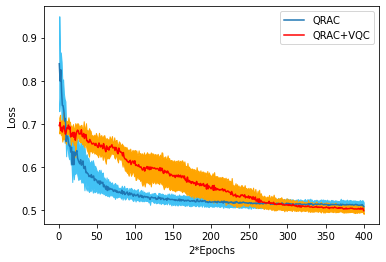

In [70]:
mean_epoch = np.mean(np.array(hist_qrac['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

mean_epoch = np.mean(np.array(hist_qrac_vqc['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac_vqc['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC+VQC', color='r')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

plt.xlabel('2*Epochs')
plt.ylabel('Loss')

plt.legend()

In [47]:
import glob

results = []

for model_name in glob.glob('models/bc_QRAC_fold_*.npz'):
    qsvm = VQC(SPSA(0), feature_map, var_form, training_input)
    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)

    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
    qsvm.run(quantum_instance)
    qsvm.load_model(model_name)
    results.append(qsvm.predict(data_test))

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  
2020-07-30 02:38:01,247:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 0, 'optimization_

2020-07-30 02:38:59,532:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 1.1475298
2020-07-30 02:38:59,533:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 26.459423542022705 seconds.
Found opt_params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] in 3 evals
2020-07-30 02:38:59,535:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-30 02:39:02,666:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 02:39:04,204:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pas

2020-07-30 02:40:02,117:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.144336633326457
2020-07-30 02:40:02,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 1.1443366
2020-07-30 02:40:02,118:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 26.263785362243652 seconds.
Found opt_params [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] in 3 evals
2020-07-30 02:40:02,120:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-30 02:40:05,033:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-30 02:40:06,822:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx'

In [55]:
av_submission = []
majority_vote = []

for result in results:
    pred_av, pred_maj = np.round(results[0][0][:,1]).astype(np.float32), results[0][1].astype(np.float32)
    av_submission.append(pred_av)
    majority_vote.append(pred_maj)
    
av_submission = np.round(np.mean(av_submission, axis=0)).astype(np.int32)
majority_vote = np.round(np.mean(majority_vote, axis=0)).astype(np.int32)

In [58]:
av_submission - majority_vote

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
majority_vote

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [60]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

# prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(av_submission, 'av_submission.csv')

In [36]:
prediction = np.zeros(len(df_test))
record_test_result_for_kaggle(prediction, 'stupid_submission.csv')

In [ ]:
qsvm_encode.save_model('models/Titanic_VQC')

In [26]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC.npz')

In [28]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-09 00:33:37,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


NameError: name 'f1' is not defined

In [33]:
np.mean(prediction == y_train), f1_score(prediction, y_train)

(0.675645342312009, 0.5743740795287187)

# Continuous+mix encoding (VQC + QRAC)

In [17]:
df_train, df_test, y, _ = load_titanic_pd('train.csv', 'test.csv', False)

/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = numer_map[df[col][i]]
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value


     Survived  Pclass Sex Age  SibSp  Parch     Fare Embarked
0           0       3   0  22      1      0   7.2500        0
1           1       1   1  38      1      0  71.2833        1
2           1       3   1  26      0      0   7.9250        0
3           1       1   1  35      1      0  53.1000        0
4           0       3   0  35      0      0   8.0500        0
..        ...     ...  ..  ..    ...    ...      ...      ...
886         0       2   0  27      0      0  13.0000        0
887         1       1   1  19      0      0  30.0000        0
888         0       3   1  30      1      2  23.4500        0
889         1       1   0  26      0      0  30.0000        1
890         0       3   0  32      0      0   7.7500        2

[891 rows x 8 columns]


/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value


In [18]:
df_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22,1,0,7.2500,0
1,1,1,38,1,0,71.2833,1
2,3,1,26,0,0,7.9250,0
3,1,1,35,1,0,53.1000,0
4,3,0,35,0,0,8.0500,0
...,...,...,...,...,...,...,...
886,2,0,27,0,0,13.0000,0
887,1,1,19,0,0,30.0000,0
888,3,1,30,1,2,23.4500,0
889,1,0,26,0,0,30.0000,1


In [19]:
df_train['Fare'] = np.log(df_train['Fare'] + 1)
df_test['Fare'] = np.log(df_test['Fare'].astype(np.float32) + 1)

In [20]:
df_train['Age'] = df_train['Age'] / 60
df_test['Age'] = df_test['Age'] / 60

In [21]:
cat_col = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
num_col = ['Age', 'Fare']

In [22]:
df_train_cat = df_train[cat_col]
df_test_cat = df_test[cat_col]

df_train_num = df_train[num_col]
df_test_num = df_test[num_col]

In [23]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

df_all = pd.concat([df_train_cat, df_test_cat])

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

In [24]:
data_train_num = df_train_num.values
data_test_num = df_test_num.values

In [25]:
data_train = np.concatenate([data_train, data_train_num], axis=1)
data_test = np.concatenate([data_test, data_test_num], axis=1)

In [26]:
data_train.shape, data_test.shape

((891, 10), (418, 10))

In [38]:
num_qubit

4

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


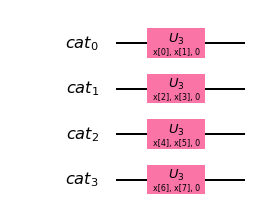

In [39]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(6, depth=4)

qr = QuantumRegister(num_qubit, 'cat')
qc = QuantumCircuit(qr)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
# tmp1 = feature_map.assign_parameters(X[:num_qubit])
# tmp2 = feature_map.assign_parameters(X[num_qubit:])

feature_map_cat = qc #+ tmp1 + tmp2 
feature_map_cat.draw('mpl')

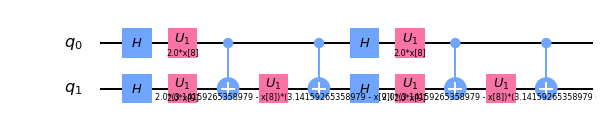

In [40]:
# Continuous circuit

X1 = Parameter('x[8]')
X2 = Parameter('x[9]')

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')

feature_map = feature_map.assign_parameters([X1, X2])

feature_map.draw('mpl')

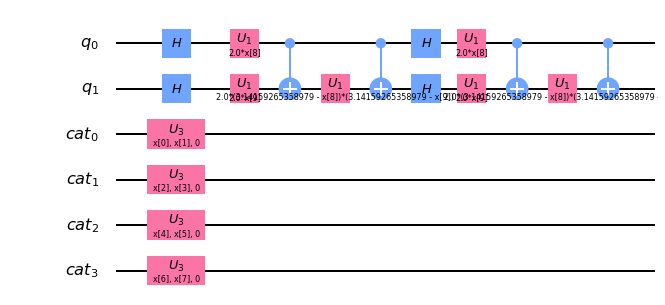

In [41]:
feature_map_all = feature_map.combine(feature_map_cat)
feature_map_all.draw('mpl')

In [42]:
data_train[-3:]

array([[0.9553166181245092, 0.7853981633974483, 2.186276035465284,
        -0.7853981633974483, 2.186276035465284, 2.356194490192345,
        2.186276035465284, -2.356194490192345, 0.5, 3.196630215920881],
       [2.186276035465284, 2.356194490192345, 2.186276035465284,
        -2.356194490192345, 2.186276035465284, -2.356194490192345,
        2.186276035465284, 2.356194490192345, 0.43333333333333335,
        3.4339872044851463],
       [0.9553166181245092, 2.356194490192345, 2.186276035465284,
        -2.356194490192345, 2.186276035465284, -2.356194490192345,
        0.9553166181245092, -2.356194490192345, 0.5333333333333333,
        2.169053700369523]], dtype=object)

In [44]:
df_train_q

array([[0.9553166181245092, 2.356194490192345, 2.186276035465284, ...,
        -2.356194490192345, 0.36666666666666664, 2.1102132003465894],
       [2.186276035465284, 0.7853981633974483, 2.186276035465284, ...,
        2.356194490192345, 0.6333333333333333, 4.2805931204649],
       [0.9553166181245092, 0.7853981633974483, 2.186276035465284, ...,
        -2.356194490192345, 0.43333333333333335, 2.188856327665703],
       ...,
       [0.9553166181245092, 0.7853981633974483, 2.186276035465284, ...,
        -2.356194490192345, 0.5, 3.196630215920881],
       [2.186276035465284, 2.356194490192345, 2.186276035465284, ...,
        2.356194490192345, 0.43333333333333335, 3.4339872044851463],
       [0.9553166181245092, 2.356194490192345, 2.186276035465284, ...,
        -2.356194490192345, 0.5333333333333333, 2.169053700369523]],
      dtype=object)

In [45]:
from sklearn.model_selection import KFold

np.random.seed(123123)

kf = KFold(5, shuffle=True)

loss_logs_31_vqc = []
results_31_vqc = []
acc_f1s_train_31_vqc = []
acc_f1s_test_31_vqc = []

def one_and_1_3(x):
    return np.concatenate([x, x[:len(x)//3]], axis=0)

def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)

    qsvm = VQC(SPSA(200), feature_map_all, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/titanic_QRAC_VQC_fold_{ro}')
    
    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_train)):
    
    
    df_train_q, y_train = data_train[train_idxs], y[train_idxs]
    df_test_q, y_test = data_train[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: one_and_1_3(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31_vqc.append(loss_log)
    results_31_vqc.append(result)
    acc_f1s_train_31_vqc.append(acc_f1_train)
    acc_f1s_test_31_vqc.append(acc_f1_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
2020-08-05 13:56:02,092:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimizatio

2020-08-05 14:00:17,924:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6929285194296951
2020-08-05 14:00:29,491:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:00:34,764:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7088090587614966
2020-08-05 14:00:46,291:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:00:52,005:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.710885197458112
2020-08-05 14:01:03,588:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:01:08,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6790541076610741
2020-08-05 14:01:20,369:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:01:26,105:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate ba

2020-08-05 14:10:09,197:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7014337355224886
2020-08-05 14:10:09,198:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA parameter c0 is 7.1304494
2020-08-05 14:10:19,910:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:10:25,628:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6935101282542258
2020-08-05 14:10:37,044:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:10:42,790:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6969934595954134
2020-08-05 14:10:42,791:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.6935101
2020-08-05 14:10:42,792:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.6969935
2020-08-05 14:10:54,139:qiskit.aqua.utils.run_circuits:INFO: Can't ski

2020-08-05 14:16:49,445:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:16:55,222:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6948386852988301
2020-08-05 14:16:55,223:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.7012633
2020-08-05 14:16:55,224:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.6948387
2020-08-05 14:17:06,613:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:17:12,448:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7066609179174325
2020-08-05 14:17:23,786:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:17:29,122:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6817703963885705
2020-08-05 14:17:29,123:qiskit.aqua.components.optimizers.spsa:DE

2020-08-05 14:23:18,584:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:23:23,839:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6305747339278235
2020-08-05 14:23:35,409:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:23:40,654:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6258190179602063
2020-08-05 14:23:40,655:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: 0.6305747
2020-08-05 14:23:40,655:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: 0.6258190
2020-08-05 14:23:51,978:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:23:57,758:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.635558396029354
2020-08-05 14:24:09,018:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-05 14:29:52,739:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 34: 0.6454685
2020-08-05 14:29:52,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 34: 0.6587759
2020-08-05 14:30:04,171:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:30:09,529:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6664120273344004
2020-08-05 14:30:21,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:30:27,002:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6368752402118087
2020-08-05 14:30:27,003:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.6664120
2020-08-05 14:30:27,003:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.6368752
2020-08-05 14:30:38,250:qiskit.aqua.utils.run_

2020-08-05 14:36:34,807:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:36:40,084:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6336859588049975
2020-08-05 14:36:40,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.6316256
2020-08-05 14:36:40,086:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.6336860
2020-08-05 14:36:51,323:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:36:57,052:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6356264203763518
2020-08-05 14:37:08,151:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:37:14,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6238181010563532
2020-08-05 14:37:14,050:qiskit.aqua.components.optimizers.spsa:DE

2020-08-05 14:43:04,137:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:43:09,992:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6143599047962346
2020-08-05 14:43:21,282:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:43:27,104:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6146561068364045
2020-08-05 14:43:27,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: 0.6143599
2020-08-05 14:43:27,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.6146561
2020-08-05 14:43:38,403:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:43:43,630:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6218650548328123
2020-08-05 14:43:55,236:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-05 14:49:42,612:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 69: 0.6070464
2020-08-05 14:49:42,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 69: 0.5922493
2020-08-05 14:49:54,103:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:50:00,015:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6014822244899575
2020-08-05 14:50:11,452:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:50:17,191:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5966133586116898
2020-08-05 14:50:17,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.6014822
2020-08-05 14:50:17,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.5966134
2020-08-05 14:50:28,757:qiskit.aqua.utils.run_

2020-08-05 14:56:27,042:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:56:32,350:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5843676563357578
2020-08-05 14:56:32,351:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.5691600
2020-08-05 14:56:32,352:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.5843677
2020-08-05 14:56:43,938:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:56:49,745:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5739048308784891
2020-08-05 14:57:01,193:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 14:57:06,471:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5790898270986513
2020-08-05 14:57:06,472:qiskit.aqua.components.optimizers.spsa:DE

2020-08-05 15:02:59,268:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:03:05,093:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5621735053269359
2020-08-05 15:03:16,083:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:03:21,361:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5627079404684726
2020-08-05 15:03:21,362:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: 0.5621735
2020-08-05 15:03:21,363:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.5627079
2020-08-05 15:03:32,847:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:03:38,690:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5617259050784515
2020-08-05 15:03:49,698:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-05 15:09:35,426:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 104: 0.5479004
2020-08-05 15:09:35,426:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 104: 0.5508585
2020-08-05 15:09:47,130:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:09:52,408:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5485726019640738
2020-08-05 15:10:03,905:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:10:09,679:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5501554560859719
2020-08-05 15:10:09,680:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.5485726
2020-08-05 15:10:09,681:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.5501555
2020-08-05 15:10:21,307:qiskit.aqua.utils.

2020-08-05 15:16:17,792:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:16:23,592:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5420708267262466
2020-08-05 15:16:23,594:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.5472080
2020-08-05 15:16:23,594:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 116: 0.5420708
2020-08-05 15:16:35,006:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:16:40,744:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5482107261067617
2020-08-05 15:16:52,073:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:16:57,782:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5337833249557385
2020-08-05 15:16:57,783:qiskit.aqua.components.optimizers.spsa:

2020-08-05 15:22:48,014:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:22:53,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5381434061096899
2020-08-05 15:23:05,089:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:23:10,837:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5302327336954996
2020-08-05 15:23:10,838:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: 0.5381434
2020-08-05 15:23:10,839:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 0.5302327
2020-08-05 15:23:22,539:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:23:27,854:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5323481104081554
2020-08-05 15:23:39,466:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 15:29:25,065:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 139: 0.5248227
2020-08-05 15:29:25,065:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 139: 0.5376930
2020-08-05 15:29:36,437:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:29:42,226:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5320556290027814
2020-08-05 15:29:53,530:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:29:58,753:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5264667529637677
2020-08-05 15:29:58,754:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 140: 0.5320556
2020-08-05 15:29:58,755:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 140: 0.5264668
2020-08-05 15:30:10,154:qiskit.aqua.utils.

2020-08-05 15:36:05,977:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:36:11,282:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5252560573894763
2020-08-05 15:36:11,283:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.5248460
2020-08-05 15:36:11,283:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 151: 0.5252561
2020-08-05 15:36:23,216:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:36:28,987:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5272607713212262
2020-08-05 15:36:40,031:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:36:45,779:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5230919840412291
2020-08-05 15:36:45,780:qiskit.aqua.components.optimizers.spsa:

2020-08-05 15:42:38,031:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:42:43,745:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5210453122595153
2020-08-05 15:42:55,233:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:43:00,512:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5258825129678071
2020-08-05 15:43:00,513:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: 0.5210453
2020-08-05 15:43:00,514:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 0.5258825
2020-08-05 15:43:12,052:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:43:17,799:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5224222866627158
2020-08-05 15:43:29,152:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 15:49:15,524:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 174: 0.5203925
2020-08-05 15:49:15,525:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 174: 0.5230839
2020-08-05 15:49:26,848:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:49:32,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5180122857743207
2020-08-05 15:49:43,718:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:49:49,490:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5235027420112789
2020-08-05 15:49:49,491:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: 0.5180123
2020-08-05 15:49:49,492:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: 0.5235027
2020-08-05 15:50:00,707:qiskit.aqua.utils.

2020-08-05 15:55:57,652:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:56:03,396:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5111853703271427
2020-08-05 15:56:03,397:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.5220270
2020-08-05 15:56:03,397:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 186: 0.5111854
2020-08-05 15:56:15,058:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:56:20,379:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5170435059130108
2020-08-05 15:56:32,189:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 15:56:37,903:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.514067560039749
2020-08-05 15:56:37,904:qiskit.aqua.components.optimizers.spsa:D

2020-08-05 16:02:29,444:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:02:35,200:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5172996451260982
2020-08-05 16:02:46,696:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:02:52,482:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5129441698171762
2020-08-05 16:02:52,483:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: 0.5172996
2020-08-05 16:02:52,484:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: 0.5129442
2020-08-05 16:03:03,513:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:03:09,257:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5171563161963983
2020-08-05 16:03:20,258:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 16:05:10,696:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6870454622959618
2020-08-05 16:05:22,540:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:05:27,832:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6708928695777346
2020-08-05 16:05:39,234:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:05:44,983:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6881890906810575
2020-08-05 16:05:56,023:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:06:01,770:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6891223913182228
2020-08-05 16:06:13,501:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:06:18,808:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-08-05 16:15:09,403:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6798892448956305
2020-08-05 16:15:20,471:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:15:26,254:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6680887869459741
2020-08-05 16:15:26,255:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 20 of 25
2020-08-05 16:15:37,281:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:15:43,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6789341096221416
2020-08-05 16:15:54,721:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:16:00,005:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6638400268275672
2020-08-05 16:16:11,822:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneT

2020-08-05 16:22:48,808:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 7: 0.6783320
2020-08-05 16:22:48,808:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 7: 0.6980302
2020-08-05 16:23:00,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:23:05,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6742109989612441
2020-08-05 16:23:17,092:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:23:22,877:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6695503496619335
2020-08-05 16:23:22,878:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 8: 0.6742110
2020-08-05 16:23:22,878:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 8: 0.6695503
2020-08-05 16:23:33,916:qiskit.aqua.utils.run_circ

2020-08-05 16:29:32,784:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:29:38,609:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6791838053028317
2020-08-05 16:29:38,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 19: 0.6609381
2020-08-05 16:29:38,611:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 19: 0.6791838
2020-08-05 16:29:50,156:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:29:55,480:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6589573772580122
2020-08-05 16:30:06,718:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:30:12,509:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.679825871952068
2020-08-05 16:30:12,510:qiskit.aqua.components.optimizers.spsa:DEB

2020-08-05 16:36:04,897:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:36:10,190:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6756881146822178
2020-08-05 16:36:21,735:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:36:27,554:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.673485812370258
2020-08-05 16:36:27,555:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 31: 0.6756881
2020-08-05 16:36:27,556:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: 0.6734858
2020-08-05 16:36:38,989:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:36:44,293:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6760918401553371
2020-08-05 16:36:56,116:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-05 16:42:42,326:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 42: 0.6505218
2020-08-05 16:42:42,327:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 42: 0.6456756
2020-08-05 16:42:53,927:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:42:59,212:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6509255907577215
2020-08-05 16:43:10,866:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:43:16,617:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6439782535718973
2020-08-05 16:43:16,618:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: 0.6509256
2020-08-05 16:43:16,619:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: 0.6439783
2020-08-05 16:43:28,089:qiskit.aqua.utils.run_

2020-08-05 16:49:24,951:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:49:30,337:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6357409213440604
2020-08-05 16:49:30,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 54: 0.6291115
2020-08-05 16:49:30,339:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 54: 0.6357409
2020-08-05 16:49:42,412:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:49:47,641:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6334347576851935
2020-08-05 16:49:59,375:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:50:04,627:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6259356504649385
2020-08-05 16:50:04,628:qiskit.aqua.components.optimizers.spsa:DE

2020-08-05 16:55:56,477:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:56:01,750:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6289703461188303
2020-08-05 16:56:13,056:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:56:18,945:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.625667080864874
2020-08-05 16:56:18,945:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 66: 0.6289703
2020-08-05 16:56:18,946:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 66: 0.6256671
2020-08-05 16:56:29,907:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 16:56:35,634:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6230775138024531
2020-08-05 16:56:46,616:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-05 17:02:32,413:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 0.6108558
2020-08-05 17:02:32,413:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 0.6224542
2020-08-05 17:02:44,109:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:02:49,407:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6089756414648351
2020-08-05 17:03:01,261:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:03:06,563:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6202613228349723
2020-08-05 17:03:06,564:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 78: 0.6089756
2020-08-05 17:03:06,565:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: 0.6202613
2020-08-05 17:03:18,441:qiskit.aqua.utils.run_

2020-08-05 17:09:16,236:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:09:21,492:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6095921761681737
2020-08-05 17:09:21,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 89: 0.6101436
2020-08-05 17:09:21,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 89: 0.6095922
2020-08-05 17:09:32,997:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:09:38,817:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6012986388230135
2020-08-05 17:09:50,077:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:09:55,899:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6171574760151797
2020-08-05 17:09:55,900:qiskit.aqua.components.optimizers.spsa:DE

2020-08-05 17:15:47,809:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:15:53,063:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6003531525105157
2020-08-05 17:16:04,484:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:16:09,765:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5985136520749202
2020-08-05 17:16:09,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 101: 0.6003532
2020-08-05 17:16:09,767:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 101: 0.5985137
2020-08-05 17:16:21,429:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:16:27,174:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.609483987178383
2020-08-05 17:16:38,649:qiskit.aqua.utils.run_circuits:INFO: Can

2020-08-05 17:22:24,586:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 0.5901789
2020-08-05 17:22:24,586:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 0.5859481
2020-08-05 17:22:36,122:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:22:41,457:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5737291687537989
2020-08-05 17:22:53,184:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:22:58,397:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6005986405417334
2020-08-05 17:22:58,398:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 113: 0.5737292
2020-08-05 17:22:58,399:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 113: 0.6005986
2020-08-05 17:23:10,367:qiskit.aqua.utils.

2020-08-05 17:29:08,854:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:29:14,603:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5606663510583283
2020-08-05 17:29:14,604:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 124: 0.5622743
2020-08-05 17:29:14,604:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 124: 0.5606664
2020-08-05 17:29:25,911:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:29:31,658:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5545655190587865
2020-08-05 17:29:42,735:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:29:48,066:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5628078817395337
2020-08-05 17:29:48,067:qiskit.aqua.components.optimizers.spsa:

2020-08-05 17:35:40,401:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:35:45,658:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5338391270981566
2020-08-05 17:35:57,232:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:36:03,059:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5346264794504508
2020-08-05 17:36:03,060:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 136: 0.5338391
2020-08-05 17:36:03,060:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 136: 0.5346265
2020-08-05 17:36:14,255:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:36:20,097:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5313359283171059
2020-08-05 17:36:31,256:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 17:42:16,124:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 0.5233712
2020-08-05 17:42:16,125:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 147: 0.5282957
2020-08-05 17:42:27,740:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:42:33,518:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5305772469052101
2020-08-05 17:42:45,165:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:42:50,921:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5196083949837349
2020-08-05 17:42:50,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 148: 0.5305772
2020-08-05 17:42:50,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 148: 0.5196084
2020-08-05 17:43:02,365:qiskit.aqua.utils.

2020-08-05 17:48:58,667:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:49:04,405:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5221969472112238
2020-08-05 17:49:04,406:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 159: 0.5130605
2020-08-05 17:49:04,406:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 159: 0.5221969
2020-08-05 17:49:15,575:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:49:21,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5171520589866336
2020-08-05 17:49:32,363:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:49:38,159:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5175598017515003
2020-08-05 17:49:38,160:qiskit.aqua.components.optimizers.spsa:

2020-08-05 17:55:28,448:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:55:34,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5128489779612352
2020-08-05 17:55:45,622:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:55:50,868:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5164342245205766
2020-08-05 17:55:50,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 171: 0.5128490
2020-08-05 17:55:50,870:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 171: 0.5164342
2020-08-05 17:56:02,629:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 17:56:07,926:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.51422481314248
2020-08-05 17:56:19,693:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-05 18:02:04,648:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 182: 0.5116784
2020-08-05 18:02:04,649:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 182: 0.5101280
2020-08-05 18:02:15,533:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:02:21,294:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5053122758805093
2020-08-05 18:02:32,803:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:02:38,109:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5093363492190777
2020-08-05 18:02:38,110:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 183: 0.5053123
2020-08-05 18:02:38,111:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 183: 0.5093363
2020-08-05 18:02:49,896:qiskit.aqua.utils.

2020-08-05 18:10:51,057:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5065510463303717
2020-08-05 18:11:03,025:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:11:08,267:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5031833034455876
2020-08-05 18:11:08,268:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: 0.5065510
2020-08-05 18:11:08,269:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: 0.5031833
2020-08-05 18:11:19,947:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:11:25,169:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5078928314109646
2020-08-05 18:11:36,656:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:11:42,419:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-05 18:13:21,944:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:13:27,211:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6944616949033352
2020-08-05 18:13:38,756:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:13:44,485:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7110660069196024
2020-08-05 18:13:56,059:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:14:01,321:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7121900578494434
2020-08-05 18:14:12,642:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:14:17,883:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7157643263738095
2020-08-05 18:14:29,512:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-08-05 18:23:17,410:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:23:22,616:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7026233121406413
2020-08-05 18:23:34,309:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:23:40,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7179330212405263
2020-08-05 18:23:40,115:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 20 of 25
2020-08-05 18:23:51,363:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:23:57,116:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6933708017380255
2020-08-05 18:24:08,376:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:24:14,165:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.706

2020-08-05 18:31:01,738:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6691928261833854
2020-08-05 18:31:01,739:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 7: 0.6680232
2020-08-05 18:31:01,739:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 7: 0.6691928
2020-08-05 18:31:13,561:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:31:19,414:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6681082893643676
2020-08-05 18:31:30,906:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:31:36,179:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6673667757789786
2020-08-05 18:31:36,180:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 8: 0.6681083
2020-08-05 18:31:36,180:qiskit.aqua.components.optimizers.s

2020-08-05 18:37:32,961:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.70690046628159
2020-08-05 18:37:44,735:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:37:50,527:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6832161670485781
2020-08-05 18:37:50,528:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 19: 0.7069005
2020-08-05 18:37:50,529:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 19: 0.6832162
2020-08-05 18:38:02,135:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:38:07,386:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7103351152992389
2020-08-05 18:38:18,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:38:24,848:qiskit.aqua.algorithms.classifiers.vqc:DEBU

2020-08-05 18:44:05,902:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 30: 0.6623906
2020-08-05 18:44:17,415:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:44:22,671:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6593172724573332
2020-08-05 18:44:34,383:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:44:40,218:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.670315353012431
2020-08-05 18:44:40,219:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 31: 0.6593173
2020-08-05 18:44:40,220:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: 0.6703154
2020-08-05 18:44:51,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:44:57,175:qiskit.aqua.algorithms.classifie

2020-08-05 18:52:52,926:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.620557458495903
2020-08-05 18:53:04,257:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:53:09,521:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6269044446292001
2020-08-05 18:53:09,522:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.6205575
2020-08-05 18:53:09,523:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.6269044
2020-08-05 18:53:21,078:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:53:26,828:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6280862033430651
2020-08-05 18:53:38,423:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 18:53:43,770:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-08-05 19:00:44,540:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:00:50,373:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6038851100255487
2020-08-05 19:01:01,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:01:06,908:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6211442702106756
2020-08-05 19:01:06,909:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 60: 0.6038851
2020-08-05 19:01:06,910:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 60: 0.6211443
2020-08-05 19:01:18,429:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:01:24,310:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6161561147388958
2020-08-05 19:01:35,958:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-05 19:07:21,943:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 71: 0.6080448
2020-08-05 19:07:21,943:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 71: 0.5959079
2020-08-05 19:07:33,750:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:07:39,047:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6024302020612194
2020-08-05 19:07:50,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:07:55,819:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6019936933037328
2020-08-05 19:07:55,820:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 72: 0.6024302
2020-08-05 19:07:55,821:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 72: 0.6019937
2020-08-05 19:08:07,169:qiskit.aqua.utils.run_

2020-08-05 19:14:04,753:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:14:10,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5816037060629032
2020-08-05 19:14:10,620:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 83: 0.5730398
2020-08-05 19:14:10,621:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 83: 0.5816037
2020-08-05 19:14:22,019:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:14:27,276:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5687378924190724
2020-08-05 19:14:38,828:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:14:44,140:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5887749070180521
2020-08-05 19:14:44,141:qiskit.aqua.components.optimizers.spsa:DE

2020-08-05 19:20:35,446:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:20:40,684:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5579463191920166
2020-08-05 19:20:52,505:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:20:58,207:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5497842516508109
2020-08-05 19:20:58,208:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 95: 0.5579463
2020-08-05 19:20:58,208:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 95: 0.5497843
2020-08-05 19:21:09,573:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:21:14,847:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5545509530378684
2020-08-05 19:21:26,960:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-05 19:27:11,831:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 106: 0.5403631
2020-08-05 19:27:11,832:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 106: 0.5400242
2020-08-05 19:27:23,163:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:27:28,926:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5420148502840548
2020-08-05 19:27:40,212:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:27:45,909:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.53527994173815
2020-08-05 19:27:45,910:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 107: 0.5420149
2020-08-05 19:27:45,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 107: 0.5352799
2020-08-05 19:27:57,448:qiskit.aqua.utils.ru

2020-08-05 19:33:55,778:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:34:01,056:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5123397029696655
2020-08-05 19:34:01,057:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 118: 0.5102864
2020-08-05 19:34:01,057:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 118: 0.5123397
2020-08-05 19:34:12,601:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:34:18,427:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5087175068499191
2020-08-05 19:34:29,902:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:34:35,684:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5147653812447159
2020-08-05 19:34:35,685:qiskit.aqua.components.optimizers.spsa:

2020-08-05 19:40:28,573:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:40:33,812:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5054948147367674
2020-08-05 19:40:45,475:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:40:50,786:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4992328736472928
2020-08-05 19:40:50,787:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 130: 0.5054948
2020-08-05 19:40:50,788:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 130: 0.4992329
2020-08-05 19:41:02,280:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:41:07,616:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5002310534392231
2020-08-05 19:41:19,313:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 19:47:06,043:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 141: 0.4991498
2020-08-05 19:47:06,044:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 141: 0.4930782
2020-08-05 19:47:17,688:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:47:22,977:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49573836979870645
2020-08-05 19:47:34,370:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:47:40,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49541306152195985
2020-08-05 19:47:40,144:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 142: 0.4957384
2020-08-05 19:47:40,145:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 142: 0.4954131
2020-08-05 19:47:51,500:qiskit.aqua.util

2020-08-05 19:53:48,456:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:53:53,690:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5010156366306843
2020-08-05 19:53:53,691:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 153: 0.4910310
2020-08-05 19:53:53,692:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 153: 0.5010156
2020-08-05 19:54:05,324:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:54:11,154:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4975765098888787
2020-08-05 19:54:22,758:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 19:54:27,968:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.493152841638702
2020-08-05 19:54:27,969:qiskit.aqua.components.optimizers.spsa:D

2020-08-05 20:00:20,829:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:00:26,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48973504587982786
2020-08-05 20:00:37,925:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:00:43,741:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4936947956457826
2020-08-05 20:00:43,742:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 165: 0.4897350
2020-08-05 20:00:43,742:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 165: 0.4936948
2020-08-05 20:00:55,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:01:00,467:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48983032340076266
2020-08-05 20:01:12,268:qiskit.aqua.utils.run_circuits:INFO: 

2020-08-05 20:06:57,696:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 176: 0.4900938
2020-08-05 20:06:57,696:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 176: 0.4908023
2020-08-05 20:07:09,673:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:07:14,960:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49132240043213743
2020-08-05 20:07:26,652:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:07:32,425:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4906923933659382
2020-08-05 20:07:32,426:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: 0.4913224
2020-08-05 20:07:32,427:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 177: 0.4906924
2020-08-05 20:07:43,944:qiskit.aqua.utils

2020-08-05 20:13:40,103:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:13:45,397:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49012593840693397
2020-08-05 20:13:45,397:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 188: 0.4908284
2020-08-05 20:13:45,398:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 188: 0.4901259
2020-08-05 20:13:56,840:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:14:02,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49091553012411815
2020-08-05 20:14:13,703:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:14:19,336:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4909900564857618
2020-08-05 20:14:19,337:qiskit.aqua.components.optimizers.sps

2020-08-05 20:20:09,949:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:20:15,219:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4866149875057415
2020-08-05 20:20:15,220:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 0.4866150
2020-08-05 20:20:15,222:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 7676.100044727325 seconds.
Found opt_params [ 1.47624810e+00 -3.65004400e+00 -2.15736910e+00  4.03464648e+00
  1.28114557e+00 -2.29874961e-01  9.11606568e-01 -2.00464156e-01
  1.37969438e-01  2.24295841e+00  1.49423853e+00 -2.75610861e+00
  2.80320444e+00  3.30635080e+00  2.17137819e+00  2.08193926e+00
 -5.71033072e-03  4.64823147e+00  2.70718192e+00  2.35718923e+00
 -2.33330592e+00 -1.33174823e+00  2.68097797e+00 -1.12037328e+00
 -3.81237682e-01  6.87361735e+00 -5.52641593e-01  4.02927856e-01
 -2.39692359e+00 -1.60355352e+00 -5.95264093e-01  6.33914182e-01
  7.

2020-08-05 20:23:09,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7289651404095794
2020-08-05 20:23:21,308:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:23:26,584:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6927078482045526
2020-08-05 20:23:26,585:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 5 of 25
2020-08-05 20:23:38,405:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:23:43,716:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6992946503959337
2020-08-05 20:23:55,440:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:24:01,293:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7040870369987319
2020-08-05 20:24:12,631:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneTy

2020-08-05 20:33:03,112:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:33:09,011:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7082215117153331
2020-08-05 20:33:20,379:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:33:25,665:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6950442846356266
2020-08-05 20:33:37,113:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:33:42,902:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7115384392494801
2020-08-05 20:33:54,204:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:33:59,502:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7028804751494414
2020-08-05 20:34:11,505:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-08-05 20:40:28,712:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:40:34,502:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6675770706262976
2020-08-05 20:40:34,502:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: 0.6688867
2020-08-05 20:40:34,503:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 9: 0.6675771
2020-08-05 20:40:45,488:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:40:51,213:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.662874229639429
2020-08-05 20:41:03,213:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:41:08,393:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.673967221586598
2020-08-05 20:41:08,394:qiskit.aqua.components.optimizers.spsa:DEBUG:

2020-08-05 20:47:00,314:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:47:06,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6508402185334721
2020-08-05 20:47:17,845:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:47:23,097:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.626715114207281
2020-08-05 20:47:23,098:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 21: 0.6508402
2020-08-05 20:47:23,099:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 21: 0.6267151
2020-08-05 20:47:34,979:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:47:40,239:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6389531991764161
2020-08-05 20:47:51,823:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-05 20:53:38,295:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 32: 0.6338780
2020-08-05 20:53:38,296:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 32: 0.6323083
2020-08-05 20:53:50,183:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:53:55,918:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6199290459610165
2020-08-05 20:54:07,147:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 20:54:13,001:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6479572357652268
2020-08-05 20:54:13,002:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 33: 0.6199290
2020-08-05 20:54:13,003:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 33: 0.6479572
2020-08-05 20:54:24,062:qiskit.aqua.utils.run_

2020-08-05 21:00:20,582:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:00:26,346:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5759053531466024
2020-08-05 21:00:26,347:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: 0.6084372
2020-08-05 21:00:26,348:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 44: 0.5759054
2020-08-05 21:00:38,080:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:00:43,377:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.581378903306527
2020-08-05 21:00:54,960:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:01:00,770:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5719832107005399
2020-08-05 21:01:00,770:qiskit.aqua.components.optimizers.spsa:DEB

2020-08-05 21:06:52,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:06:58,343:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5366462344244263
2020-08-05 21:07:09,782:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:07:15,634:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5371326656516071
2020-08-05 21:07:15,635:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 56: 0.5366462
2020-08-05 21:07:15,635:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 56: 0.5371327
2020-08-05 21:07:27,282:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:07:33,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5384518040778894
2020-08-05 21:07:44,625:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-05 21:13:32,069:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 67: 0.5413666
2020-08-05 21:13:32,069:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 67: 0.5269514
2020-08-05 21:13:43,470:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:13:48,750:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5262713765675083
2020-08-05 21:14:00,829:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:14:06,582:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5344506506357566
2020-08-05 21:14:06,583:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 68: 0.5262714
2020-08-05 21:14:06,584:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 68: 0.5344507
2020-08-05 21:14:17,851:qiskit.aqua.utils.run_

2020-08-05 21:20:17,322:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:20:22,628:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.515877069953317
2020-08-05 21:20:22,629:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: 0.5237267
2020-08-05 21:20:22,630:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 79: 0.5158771
2020-08-05 21:20:34,206:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:20:40,095:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5213680657857725
2020-08-05 21:20:51,422:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:20:57,195:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5190739467798116
2020-08-05 21:20:57,196:qiskit.aqua.components.optimizers.spsa:DEB

2020-08-05 21:26:49,925:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:26:55,790:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5140554974456141
2020-08-05 21:27:07,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:27:12,871:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5158860381868565
2020-08-05 21:27:12,872:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 91: 0.5140555
2020-08-05 21:27:12,872:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 91: 0.5158860
2020-08-05 21:27:24,256:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:27:30,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.520211783186632
2020-08-05 21:27:41,760:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-05 21:33:29,431:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 102: 0.5137533
2020-08-05 21:33:29,432:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 102: 0.5119669
2020-08-05 21:33:40,942:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:33:46,709:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122796337959568
2020-08-05 21:33:58,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:34:03,857:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5086939884845191
2020-08-05 21:34:03,858:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 103: 0.5122796
2020-08-05 21:34:03,858:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 103: 0.5086940
2020-08-05 21:34:15,027:qiskit.aqua.utils.

2020-08-05 21:40:13,480:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:40:19,278:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5110283918188931
2020-08-05 21:40:19,279:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: 0.5088912
2020-08-05 21:40:19,280:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 114: 0.5110284
2020-08-05 21:40:30,284:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:40:36,090:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5084749965825777
2020-08-05 21:40:47,445:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:40:52,801:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5127562299699401
2020-08-05 21:40:52,802:qiskit.aqua.components.optimizers.spsa:

2020-08-05 21:46:45,415:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:46:50,670:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5079857048163138
2020-08-05 21:47:02,552:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:47:08,411:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5105690090391293
2020-08-05 21:47:08,412:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 126: 0.5079857
2020-08-05 21:47:08,412:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 126: 0.5105690
2020-08-05 21:47:19,819:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:47:25,645:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124583782569908
2020-08-05 21:47:36,560:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 21:53:23,702:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 137: 0.5084002
2020-08-05 21:53:23,703:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 137: 0.5086898
2020-08-05 21:53:35,429:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:53:40,726:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5138031793872114
2020-08-05 21:53:52,306:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 21:53:58,138:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5049068905431321
2020-08-05 21:53:58,139:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 138: 0.5138032
2020-08-05 21:53:58,140:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 138: 0.5049069
2020-08-05 21:54:09,642:qiskit.aqua.utils.

2020-08-05 22:00:07,871:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:00:13,260:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5047901980275625
2020-08-05 22:00:13,261:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: 0.5074102
2020-08-05 22:00:13,262:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 149: 0.5047902
2020-08-05 22:00:25,345:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:00:31,100:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5081147211259676
2020-08-05 22:00:42,292:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:00:48,131:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5058270970610145
2020-08-05 22:00:48,133:qiskit.aqua.components.optimizers.spsa:

2020-08-05 22:06:43,483:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:06:49,379:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5083441796661801
2020-08-05 22:07:00,611:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:07:06,359:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5038909966628156
2020-08-05 22:07:06,360:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 161: 0.5083442
2020-08-05 22:07:06,361:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 161: 0.5038910
2020-08-05 22:07:17,807:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:07:23,091:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5051531247475999
2020-08-05 22:07:35,104:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 22:13:22,668:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 172: 0.5058626
2020-08-05 22:13:22,669:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 172: 0.5070847
2020-08-05 22:13:34,654:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:13:40,411:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5056095337727581
2020-08-05 22:13:51,694:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:13:57,544:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5028805640710474
2020-08-05 22:13:57,545:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 173: 0.5056095
2020-08-05 22:13:57,546:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 173: 0.5028806
2020-08-05 22:14:08,582:qiskit.aqua.utils.

2020-08-05 22:20:07,183:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:20:12,974:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5041550493500386
2020-08-05 22:20:12,975:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: 0.5061416
2020-08-05 22:20:12,976:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: 0.5041550
2020-08-05 22:20:24,282:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:20:30,121:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5049103925647994
2020-08-05 22:20:41,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:20:47,014:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5050967024430472
2020-08-05 22:20:47,014:qiskit.aqua.components.optimizers.spsa:

2020-08-05 22:26:41,130:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:26:46,383:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5046274130934023
2020-08-05 22:26:58,246:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:27:04,064:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5051543700819167
2020-08-05 22:27:04,065:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 196: 0.5046274
2020-08-05 22:27:04,066:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 196: 0.5051544
2020-08-05 22:27:15,527:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:27:21,375:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5029210300346244
2020-08-05 22:27:32,526:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-05 22:29:23,561:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-05 22:29:23,562:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-05 22:29:23,562:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-05 22:29:23,563:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-08-05 22:29:35,210:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:29:40,986:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6954961876501816
2020-08-05 22:29:52,503:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:29:57,756:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6967739068991539
2020-08-05 22:30:09,471:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-08-05 22:38:57,745:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:39:03,551:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6939678521951905
2020-08-05 22:39:14,478:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:39:20,458:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6919693501913494
2020-08-05 22:39:31,912:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:39:37,261:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7153156375064819
2020-08-05 22:39:48,851:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:39:54,101:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.699439976097232
2020-08-05 22:40:05,808:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validati

2020-08-05 22:47:02,474:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.7030389
2020-08-05 22:47:14,027:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:47:19,309:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6958762290469275
2020-08-05 22:47:30,968:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:47:36,237:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6931335060367563
2020-08-05 22:47:36,238:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6958762
2020-08-05 22:47:36,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6931335
2020-08-05 22:47:47,954:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:47:53,834:qiskit.aqua.algorithms.classifiers

2020-08-05 22:53:51,109:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6892700763689446
2020-08-05 22:53:51,110:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6635455
2020-08-05 22:53:51,111:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6892701
2020-08-05 22:54:02,866:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:54:08,689:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6584147869978023
2020-08-05 22:54:19,632:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 22:54:25,409:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.65906729794674
2020-08-05 22:54:25,410:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6584148
2020-08-05 22:54:25,411:qiskit.aqua.components.optimizers.

2020-08-05 23:00:24,362:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6143796495905663
2020-08-05 23:00:35,751:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:00:41,538:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6514274078892959
2020-08-05 23:00:41,538:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.6143796
2020-08-05 23:00:41,539:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.6514274
2020-08-05 23:00:52,923:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:00:58,226:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6217911707943188
2020-08-05 23:01:09,812:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:01:15,630:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-05 23:06:56,457:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.6334574
2020-08-05 23:07:07,700:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:07:12,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6286798747392583
2020-08-05 23:07:24,850:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:07:30,152:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.644998602560072
2020-08-05 23:07:30,153:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.6286799
2020-08-05 23:07:30,154:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.6449986
2020-08-05 23:07:41,789:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:07:47,601:qiskit.aqua.algorithms.classifie

2020-08-05 23:13:44,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5852532066339626
2020-08-05 23:13:44,732:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5745283
2020-08-05 23:13:44,732:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5852532
2020-08-05 23:13:56,502:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:14:02,327:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.591859689378581
2020-08-05 23:14:13,482:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:14:19,236:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5652574900863785
2020-08-05 23:14:19,237:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5918597
2020-08-05 23:14:19,237:qiskit.aqua.components.optimizers

2020-08-05 23:20:16,431:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6034124343056675
2020-08-05 23:20:27,988:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:20:33,756:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.609228228147482
2020-08-05 23:20:33,757:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.6034124
2020-08-05 23:20:33,757:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.6092282
2020-08-05 23:20:44,723:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:20:50,583:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6099430118420051
2020-08-05 23:21:01,720:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:21:07,534:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-08-05 23:26:48,037:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.5905594
2020-08-05 23:26:59,834:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:27:05,666:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.580915791949491
2020-08-05 23:27:16,783:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:27:22,555:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5791884472618487
2020-08-05 23:27:22,556:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.5809158
2020-08-05 23:27:22,557:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.5791884
2020-08-05 23:27:34,042:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:27:39,356:qiskit.aqua.algorithms.classifie

2020-08-05 23:33:35,868:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5726842813621104
2020-08-05 23:33:35,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5433320
2020-08-05 23:33:35,869:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5726843
2020-08-05 23:33:47,316:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:33:52,554:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5655506801264563
2020-08-05 23:34:04,360:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:34:10,120:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5483844640221757
2020-08-05 23:34:10,121:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5655507
2020-08-05 23:34:10,121:qiskit.aqua.components.optimizer

2020-08-05 23:40:07,514:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5462259435730936
2020-08-05 23:40:19,126:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:40:24,363:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5516837550380058
2020-08-05 23:40:24,364:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.5462259
2020-08-05 23:40:24,365:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.5516838
2020-08-05 23:40:35,882:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:40:41,715:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5396387954695356
2020-08-05 23:40:52,602:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:40:58,423:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-05 23:46:38,593:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.5452928
2020-08-05 23:46:50,513:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:46:55,806:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5480485340881135
2020-08-05 23:47:07,427:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:47:12,657:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5368802570839694
2020-08-05 23:47:12,658:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5480485
2020-08-05 23:47:12,659:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5368803
2020-08-05 23:47:24,517:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:47:29,751:qiskit.aqua.algorithms.class

2020-08-05 23:53:25,274:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5274157686447034
2020-08-05 23:53:25,275:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.5625063
2020-08-05 23:53:25,276:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.5274158
2020-08-05 23:53:36,838:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:53:42,106:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5328625283174104
2020-08-05 23:53:53,560:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-05 23:53:59,284:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5450482196012413
2020-08-05 23:53:59,285:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5328625
2020-08-05 23:53:59,285:qiskit.aqua.components.optimi

2020-08-05 23:59:55,526:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5241646060134908
2020-08-06 00:00:07,334:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:00:12,601:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.513093995195235
2020-08-06 00:00:12,602:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.5241646
2020-08-06 00:00:12,603:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.5130940
2020-08-06 00:00:23,977:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:00:29,178:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.522598967267993
2020-08-06 00:00:40,783:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:00:46,032:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-06 00:06:24,569:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.5106206
2020-08-06 00:06:36,426:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:06:41,629:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5148908608082619
2020-08-06 00:06:53,258:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:06:58,443:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.514042131007869
2020-08-06 00:06:58,444:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5148909
2020-08-06 00:06:58,444:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5140421
2020-08-06 00:07:10,179:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:07:15,418:qiskit.aqua.algorithms.classi

2020-08-06 00:13:11,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5102188960645154
2020-08-06 00:13:11,734:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5088192
2020-08-06 00:13:11,734:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5102189
2020-08-06 00:13:22,696:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:13:28,352:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5057643396204607
2020-08-06 00:13:40,096:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:13:45,370:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5099345326519835
2020-08-06 00:13:45,371:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5057643
2020-08-06 00:13:45,372:qiskit.aqua.components.optimi

2020-08-06 00:19:41,849:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5057147046424245
2020-08-06 00:19:53,361:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:19:59,121:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5114521068675882
2020-08-06 00:19:59,121:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5057147
2020-08-06 00:19:59,122:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5114521
2020-08-06 00:20:09,769:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:20:15,628:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5072550344514679
2020-08-06 00:20:27,186:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:20:32,503:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-06 00:26:11,444:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 0.5027563
2020-08-06 00:26:23,211:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:26:28,435:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5099729794034712
2020-08-06 00:26:40,124:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:26:45,844:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5058530018606229
2020-08-06 00:26:45,845:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5099730
2020-08-06 00:26:45,845:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5058530
2020-08-06 00:26:57,439:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:27:03,215:qiskit.aqua.algorithms.class

2020-08-06 00:32:59,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5041908595239936
2020-08-06 00:32:59,492:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5057186
2020-08-06 00:32:59,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5041909
2020-08-06 00:33:10,682:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:33:16,394:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5038781005155456
2020-08-06 00:33:27,919:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 00:33:33,174:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5035730102531263
2020-08-06 00:33:33,175:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5038781
2020-08-06 00:33:33,175:qiskit.aqua.components.optimi

In [47]:
import pickle

qrac_record = {
    'loss_logs': loss_logs_31_vqc,
    'result': results_31_vqc,
    'acc_f1s_train': acc_f1s_train_31_vqc,
    'acc_f1s_test': acc_f1s_test_31_vqc
}

with open('results/titanic_qrac_vqc_record.pk', 'wb') as f:
    pickle.dump(qrac_record, f)

Text(0, 0.5, 'Loss')

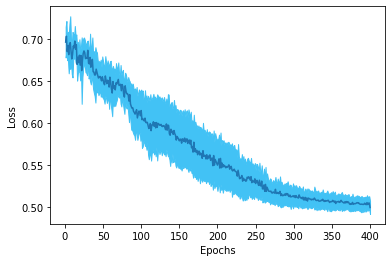

In [48]:
mean_epoch = np.mean(loss_logs_31_vqc, axis=0)[-400:]
std_epoch = np.std(loss_logs_31_vqc, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

plt.xlabel('Epochs')
plt.ylabel('Loss')

In [49]:
np.mean(acc_f1s_train_31_vqc, axis=0),np.mean(acc_f1s_test_31_vqc, axis=0)

(array([0.7881593 , 0.71123908]), array([0.78673027, 0.70964323]))

In [52]:
data_test.shape

(418, 10)

In [55]:
feature_map.draw()

┌───┐┌──────────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[8]) ├──■──»
     ├───┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[9]) ├┤ X ├»
     └───┘└──────────────┘└───┘»
«                                                                         ┌───┐»
«q_0: ─────────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[8])*(3.14159265358979 - x[9])) ├┤ X ├┤ H ├»
«     └─────────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐     »
«q_0: ┤ U1(2.0*x[8]) ├──■──»
«     ├──────────────┤┌─┴─┐»
«q_1: ┤ U1(2.0*x[9]) ├┤ X ├»
«     └──────────────┘└───┘»
«                                                                         
«q_0: ─────────────────────────────────────────────────────────────────■──
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*(3.14159265358979 - x[8])*(3.14159265358979 - x[9])) ├┤ X ├
«     └─────────────────────────────────────────────────────────────┘└───┘

In [56]:
import glob

results = []

for model_name in glob.glob('models/titanic_QRAC_VQC_fold_*.npz'):
    qsvm = VQC(SPSA(0), feature_map_all, var_form, training_input)
    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)

    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
    qsvm.run(quantum_instance)
    qsvm.load_model(model_name)
    results.append(qsvm.predict(data_test))

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  
2020-08-06 02:25:55,937:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 0, 'optimization_

2020-08-06 02:26:55,311:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-06 02:26:55,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-06 02:26:55,312:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-06 02:26:55,313:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 1
2020-08-06 02:27:07,557:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 02:27:12,807:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7045725766670833
2020-08-06 02:27:24,496:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 02:27:30,297:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6870422596289194
2020-08-06 02:27:30,298:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA pa

2020-08-06 02:28:56,475:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.

2020-08-06 02:29:56,950:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-06 02:29:56,950:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-06 02:29:56,951:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-06 02:29:56,951:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 1
2020-08-06 02:30:08,946:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 02:30:14,201:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6858174589068003
2020-08-06 02:30:26,444:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-06 02:30:31,698:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6857258666590533
2020-08-06 02:30:31,699:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA pa

In [57]:
av_submission = []
majority_vote = []

for result in results:
    pred_av, pred_maj = np.round(results[0][0][:,1]).astype(np.float32), results[0][1].astype(np.float32)
    av_submission.append(pred_av)
    majority_vote.append(pred_maj)
    
av_submission = np.round(np.mean(av_submission, axis=0)).astype(np.int32)
majority_vote = np.round(np.mean(majority_vote, axis=0)).astype(np.int32)

In [58]:
av_submission - majority_vote

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [59]:
majority_vote

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [60]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

# prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(av_submission, 'av_qrac_vqc_submission.csv')

In [ ]:
# Make training data

training_input = {
    0: data_train[y_train == 0],
    1: data_train[y_train == 1]
}

In [17]:
# 

seed = 10598

vqc_encode_with_num_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_with_num_log.append(loss)


# feature_map = ZZFeatureMap(feature_dimension=num_qubit, reps=2, entanglement='linear')
var_form = variational_forms.RYRZ(6, depth=4)

qsvm_encode = VQC(SPSA(200), feature_map_all, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  del sys.path[0]
2020-07-10 01:40:17,159:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra

2020-07-10 01:59:44,875:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6978227864943641
2020-07-10 02:00:35,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6641369808805189
2020-07-10 02:01:29,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7097806113555607
2020-07-10 02:02:21,961:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6479905685211301
2020-07-10 02:02:21,963:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 15 of 25
2020-07-10 02:03:00,663:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6597253254175388
2020-07-10 02:03:38,902:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6866470010219077
2020-07-10 02:04:18,250:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6640004356178763
2020-07-10 02:04:56,606:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6741018

2020-07-10 02:32:14,767:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.662704044552734
2020-07-10 02:32:53,947:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6858486679741306
2020-07-10 02:32:53,949:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.6627040
2020-07-10 02:32:53,950:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.6858487
2020-07-10 02:33:41,818:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.690136191475854
2020-07-10 02:34:25,082:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6884959610126431
2020-07-10 02:34:25,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.6901362
2020-07-10 02:34:25,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.6884960
2020-07-10 02:35:07,824:qiskit.aqua.algorithms.cla

2020-07-10 02:57:18,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6037414599688735
2020-07-10 02:57:18,116:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 28: 0.6215160
2020-07-10 02:57:18,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 28: 0.6037415
2020-07-10 02:57:53,390:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.598652409977434
2020-07-10 02:58:29,317:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6203714847899428
2020-07-10 02:58:29,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5986524
2020-07-10 02:58:29,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.6203715
2020-07-10 02:59:05,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6071380334062831
2020-07-10 02:59:41,722:qiskit.aqua.algorithms.cl

2020-07-10 03:17:32,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 0.5861323
2020-07-10 03:17:32,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 0.5593678
2020-07-10 03:18:09,300:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5699069421854679
2020-07-10 03:18:45,429:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5683295455137718
2020-07-10 03:18:45,431:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.5699069
2020-07-10 03:18:45,432:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.5683295
2020-07-10 03:19:20,167:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5539767280377486
2020-07-10 03:19:57,785:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5732913575904321
2020-07-10 03:19:57,787:qiskit.aqua.components.o

2020-07-10 03:37:42,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 62: 0.5241803
2020-07-10 03:38:18,163:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5222037659720453
2020-07-10 03:38:53,464:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5412051569797188
2020-07-10 03:38:53,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 63: 0.5222038
2020-07-10 03:38:53,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 63: 0.5412052
2020-07-10 03:39:28,441:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5345577958532489
2020-07-10 03:40:04,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5155660243138442
2020-07-10 03:40:04,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5345578
2020-07-10 03:40:04,232:qiskit.aqua.components.o

2020-07-10 03:58:32,754:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5188152827385304
2020-07-10 03:59:07,878:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4939710980048807
2020-07-10 03:59:07,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 0.5188153
2020-07-10 03:59:07,882:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: 0.4939711
2020-07-10 03:59:43,402:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5007676689997459
2020-07-10 04:00:19,085:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4986399900954613
2020-07-10 04:00:19,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.5007677
2020-07-10 04:00:19,089:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.4986400
2020-07-10 04:00:54,317:qiskit.aqua.algorithms.c

2020-07-10 04:19:10,918:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49384996173594764
2020-07-10 04:19:10,921:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 97: 0.4860526
2020-07-10 04:19:10,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 97: 0.4938500
2020-07-10 04:19:47,119:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4881715133680305
2020-07-10 04:20:23,110:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4913710299543273
2020-07-10 04:20:23,113:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 98: 0.4881715
2020-07-10 04:20:23,113:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 98: 0.4913710
2020-07-10 04:20:59,060:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4884164469080427
2020-07-10 04:21:33,979:qiskit.aqua.algorithms.

2020-07-10 04:39:17,634:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: 0.4846210
2020-07-10 04:39:17,636:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 114: 0.4794160
2020-07-10 04:39:53,570:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4843528813282956
2020-07-10 04:40:28,755:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48606590530747434
2020-07-10 04:40:28,758:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 115: 0.4843529
2020-07-10 04:40:28,759:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 115: 0.4860659
2020-07-10 04:41:04,546:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48317436456200946
2020-07-10 04:41:39,695:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4823931471846053
2020-07-10 04:41:39,698:qiskit.aqua.compon

2020-07-10 04:59:30,414:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 131: 0.4840897
2020-07-10 05:00:07,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4832384816247759
2020-07-10 05:00:42,353:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4824674658420433
2020-07-10 05:00:42,356:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 132: 0.4832385
2020-07-10 05:00:42,357:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 132: 0.4824675
2020-07-10 05:01:17,747:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48361449069526463
2020-07-10 05:01:53,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4815972476986018
2020-07-10 05:01:53,218:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 133: 0.4836145
2020-07-10 05:01:53,219:qiskit.aqua.compone

2020-07-10 05:20:15,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4834343242923306
2020-07-10 05:20:50,897:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47948581849516664
2020-07-10 05:20:50,899:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: 0.4834343
2020-07-10 05:20:50,900:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 149: 0.4794858
2020-07-10 05:21:26,171:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48373640511076743
2020-07-10 05:22:01,136:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48375487245934473
2020-07-10 05:22:01,138:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: 0.4837364
2020-07-10 05:22:01,139:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: 0.4837549
2020-07-10 05:22:36,388:qiskit.aqua.algor

2020-07-10 05:42:57,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48048788561384537
2020-07-10 05:42:57,511:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 166: 0.4857042
2020-07-10 05:42:57,513:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 166: 0.4804879
2020-07-10 05:43:38,417:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4787465566052345
2020-07-10 05:44:20,696:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4781982284584361
2020-07-10 05:44:20,699:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 167: 0.4787466
2020-07-10 05:44:20,700:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 167: 0.4781982
2020-07-10 05:44:57,334:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48441597922971863
2020-07-10 05:45:32,374:qiskit.aqua.algori

2020-07-10 06:03:22,448:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 183: 0.4757646
2020-07-10 06:03:22,449:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 183: 0.4791143
2020-07-10 06:03:58,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47574946472011714
2020-07-10 06:04:35,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47671805440113113
2020-07-10 06:04:35,845:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: 0.4757495
2020-07-10 06:04:35,847:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: 0.4767181
2020-07-10 06:05:11,701:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4809099666584187
2020-07-10 06:05:46,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47864556603867414
2020-07-10 06:05:46,917:qiskit.aqua.compo

In [18]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(prediction, 'encode_with_num_submission.csv')

2020-07-10 06:23:04,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


In [79]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC_withnum_SPSA.npz')

In [83]:
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
qsvm_encode.run(quantum_instance)

2020-07-10 01:30:30,638:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-10 01:30:30,641:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.14159

KeyboardInterrupt: 

In [21]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-10 09:03:49,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7878787878787878, 0.7114503816793893)

Text(0, 0.5, 'loss')

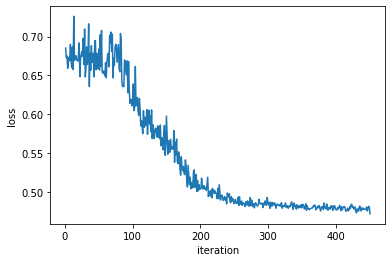

In [25]:
x_plot = np.arange(1,452)
plt.plot(x_plot, vqc_encode_with_num_log)
plt.xlabel('iteration')
plt.ylabel('loss')

# Original 3-1 Encoder with mapper

In [5]:
df_train, df_test, y_train, _ = load_titanic_pd('train.csv', 'test.csv')

/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = numer_map[df[col][i]]
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:131: SettingWithCopyWarning

     Survived  Pclass Sex Age  SibSp  Parch  Fare Embarked
0           0       3   0   2      1      0     0        0
1           1       1   1   3      1      0     3        1
2           1       3   1   2      0      0     0        0
3           1       1   1   3      1      0     3        0
4           0       3   0   3      0      0     0        0
..        ...     ...  ..  ..    ...    ...   ...      ...
886         0       2   0   2      0      0     1        0
887         1       1   1   1      0      0     3        0
888         0       3   1   3      1      2     2        0
889         1       1   0   2      0      0     3        1
890         0       3   0   3      0      0     0        2

[891 rows x 8 columns]


In [6]:
from quantum_utils import select_features
mvp_col = select_features(df_train, y_train, feat_num=4)

-----
Full features:
Final train score: 0.893378
Final F1 score: 0.854962
-----
Majority
Final train acc: 0.616162
Final train F1:0.000000
Feature rank based on importance
['Sex', 'Age', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Embarked']
Selected features: Sex,Age,Pclass,Fare


In [7]:
df_train, df_test = df_train[mvp_col], df_test[mvp_col]

In [8]:
df_q = df_train[mvp_col]

data = []

bit_each_col = []

# Check number of different category in df_all
for col in df_q.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_q[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_q.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    data.append(all_b_st)

data_train = np.array(data)



In [55]:
df_q = df_test[mvp_col]
data = []
for row in df_q.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    data.append(all_b_st)

data_test = np.array(data)

In [10]:
df = pd.DataFrame(data={
    'input_s': data_train
})

df['f1'] = df.input_s.str[:3]
df['f2'] = df.input_s.str[3:6]
df['f3'] = df.input_s.str[6:9]

df['y'] = y


In [11]:
df['y'].mean()

0.3838383838383838

In [12]:

def one_and_1_3_positive(x):
    positive = df[df.y == 1]
    return pd.concat([df, positive.iloc[:len(positive)//3]], axis=0).reindex()

df = one_and_1_3_positive(df)

In [16]:
sym_list = ['000','001','010','011','100','101','110','111']

q_columns = ['f1', 'f2', 'f3']

q_map = []

for cl in q_columns:
    sort_symbol = df[[cl,'y']].groupby(cl).mean().sort_values('y')
    neg = sort_symbol[sort_symbol.y < 0.5]
    pos = sort_symbol[sort_symbol.y >= 0.5]
    
    q_mapper = {}
    pos_sym = 0
    for idx in pos.index:
        q_mapper[idx] = sym_list[pos_sym]
        pos_sym += 1
        
    neg_sym = -1
    for idx in neg.index:
        q_mapper[idx] = sym_list[neg_sym]
        neg_sym -= 1
        
    print(sort_symbol)
        
    q_map.append(q_mapper)

q_map

            y
f1           
011  0.136364
001  0.210526
010  0.211111
000  0.370000
100  0.765957
101  0.800000
110  0.800000
111  1.000000
            y
f2           
011  0.314655
111  0.317308
110  0.466667
010  0.609524
001  0.642857
101  0.705882
            y
f3           
000  0.265027
100  0.496774
010  0.500000
110  0.643885


[{'100': '000',
  '101': '001',
  '110': '010',
  '111': '011',
  '011': '111',
  '001': '110',
  '010': '101',
  '000': '100'},
 {'010': '000',
  '001': '001',
  '101': '010',
  '011': '111',
  '111': '110',
  '110': '101'},
 {'010': '000', '110': '001', '000': '111', '100': '110'}]

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


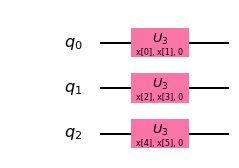

In [22]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(num_qubit, depth=4)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc 
feature_map.draw('mpl')

In [26]:
np.mean(y)

0.3838383838383838

In [18]:
from sklearn.model_selection import KFold
from quantum_utils import CustomFeatureMap

np.random.seed(123123)

kf = KFold(5, shuffle=True)

loss_logs_31 = []
results_31 = []
acc_f1s_train_31 = []
acc_f1s_test_31 = []

def one_and_1_3(x):
    return np.concatenate([x, x[:len(x)//3]], axis=0)

def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)
        
    feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
    var_form = variational_forms.RYRZ(num_qubit, depth=4)

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/titanic_QRAC_mapped_implementation_fold_{ro}')

    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_train)):
    
    
    df_train_q, y_train = data_train[train_idxs], y[train_idxs]
    df_test_q, y_test = data_train[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: one_and_1_3(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31.append(loss_log)
    results_31.append(result)
    acc_f1s_train_31.append(acc_f1_train)
    acc_f1s_test_31.append(acc_f1_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.components.feature_

2020-08-10 23:50:44,201:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7836765353910962
2020-08-10 23:51:08,490:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-10 23:51:11,046:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.769741251679613
2020-08-10 23:51:35,972:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-10 23:51:38,602:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8155302135736419
2020-08-10 23:51:38,603:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 10 of 25
2020-08-10 23:52:04,437:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-10 23:52:07,075:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7970236127928182
2020-08-10 23:52:31,434:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneTy

2020-08-11 00:06:30,034:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7510908
2020-08-11 00:06:30,035:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.8248873
2020-08-11 00:08:17,286:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:08:19,956:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8010661317247098
2020-08-11 00:08:19,957:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: 0.7261494
2020-08-11 00:08:19,957:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: 0.8010661
2020-08-11 00:08:44,896:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:08:48,108:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.626221428619651
2020-08-11 00:09:12,193:qiskit.aqua.utils.run_circu

2020-08-11 00:18:33,404:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.5636579
2020-08-11 00:18:33,404:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 13: 0.5723881
2020-08-11 00:18:58,902:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:19:01,867:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5627867285407074
2020-08-11 00:19:25,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:19:27,819:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5693681339799508
2020-08-11 00:19:27,820:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 14: 0.5627867
2020-08-11 00:19:27,821:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 14: 0.5693681
2020-08-11 00:19:52,800:qiskit.aqua.utils.run_

2020-08-11 00:29:39,115:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:29:42,330:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5430327312239766
2020-08-11 00:29:42,331:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 25: 0.5348716
2020-08-11 00:29:42,332:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 25: 0.5430327
2020-08-11 00:30:07,373:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:30:10,052:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.540080038856069
2020-08-11 00:30:34,836:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:30:37,623:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.530727701451338
2020-08-11 00:30:37,624:qiskit.aqua.components.optimizers.spsa:DEBU

2020-08-11 00:40:18,693:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:40:21,523:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5262051510864776
2020-08-11 00:40:45,256:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:40:48,423:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5231745942720321
2020-08-11 00:40:48,425:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 37: 0.5262052
2020-08-11 00:40:48,427:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 37: 0.5231746
2020-08-11 00:41:14,222:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:41:16,939:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5311185110892981
2020-08-11 00:41:42,936:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-11 00:51:00,820:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: 0.5195176
2020-08-11 00:51:00,821:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 48: 0.5156420
2020-08-11 00:51:25,462:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:51:28,075:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5177319582297298
2020-08-11 00:51:52,563:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 00:51:55,863:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5174718084999221
2020-08-11 00:51:55,864:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 49: 0.5177320
2020-08-11 00:51:55,864:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 49: 0.5174718
2020-08-11 00:52:19,749:qiskit.aqua.utils.run_

2020-08-11 01:02:07,765:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:02:10,722:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5094028057702136
2020-08-11 01:02:10,724:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 60: 0.5140906
2020-08-11 01:02:10,725:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 60: 0.5094028
2020-08-11 01:02:34,928:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:02:37,694:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5150365957240737
2020-08-11 01:03:03,205:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:03:05,835:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5146691181827501
2020-08-11 01:03:05,836:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 01:12:51,142:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:12:54,966:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5165339930370301
2020-08-11 01:13:20,723:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:13:23,269:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5141785891244826
2020-08-11 01:13:23,280:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 72: 0.5165340
2020-08-11 01:13:23,280:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 72: 0.5141786
2020-08-11 01:13:47,827:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:13:50,565:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5100367841588022
2020-08-11 01:14:13,775:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-11 01:23:31,580:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 83: 0.5075022
2020-08-11 01:23:31,582:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 83: 0.5084346
2020-08-11 01:23:56,382:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:23:59,266:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5093632776717719
2020-08-11 01:24:24,734:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:24:27,359:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5117649981714467
2020-08-11 01:24:27,360:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 84: 0.5093633
2020-08-11 01:24:27,361:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 84: 0.5117650
2020-08-11 01:24:52,378:qiskit.aqua.utils.run_

2020-08-11 01:36:29,018:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:36:31,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5041652500901861
2020-08-11 01:36:31,732:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 97: 0.5118701
2020-08-11 01:36:31,733:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 97: 0.5041653
2020-08-11 01:36:56,582:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:37:00,281:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5085078328507799
2020-08-11 01:37:24,754:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:37:27,781:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5065571982385925
2020-08-11 01:37:27,782:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 01:47:07,792:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:47:10,527:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5057925531652134
2020-08-11 01:47:34,965:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:47:37,793:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5089193433434029
2020-08-11 01:47:37,795:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 109: 0.5057926
2020-08-11 01:47:37,795:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 109: 0.5089193
2020-08-11 01:48:01,552:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:48:04,295:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5065850508392702
2020-08-11 01:48:29,507:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 01:57:51,752:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 120: 0.5084529
2020-08-11 01:57:51,753:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 120: 0.5027020
2020-08-11 01:58:14,976:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:58:18,248:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5066255337707168
2020-08-11 01:58:43,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 01:58:45,934:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5044333470000658
2020-08-11 01:58:45,940:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 121: 0.5066255
2020-08-11 01:58:45,940:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 121: 0.5044333
2020-08-11 01:59:11,607:qiskit.aqua.utils.

2020-08-11 02:08:56,397:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:08:59,010:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.504699609626218
2020-08-11 02:08:59,011:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 132: 0.5050905
2020-08-11 02:08:59,013:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 132: 0.5046996
2020-08-11 02:09:23,086:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:09:26,181:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5080812964727923
2020-08-11 02:09:50,306:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:09:53,208:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5096523964289229
2020-08-11 02:09:53,210:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 02:19:35,581:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:19:38,729:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5079565611471288
2020-08-11 02:20:03,079:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:20:05,966:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.50574960290355
2020-08-11 02:20:05,968:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 144: 0.5079566
2020-08-11 02:20:05,970:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 144: 0.5057496
2020-08-11 02:20:32,685:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:20:35,274:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5067110180761092
2020-08-11 02:21:00,208:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-11 02:32:14,445:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.5074307
2020-08-11 02:32:14,445:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.5048436
2020-08-11 02:32:39,141:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:32:42,239:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5034895428764589
2020-08-11 02:33:08,473:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:33:11,104:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5064230388314043
2020-08-11 02:33:11,104:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5034895
2020-08-11 02:33:11,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.5064230
2020-08-11 02:33:35,934:qiskit.aqua.utils.

2020-08-11 02:43:23,869:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:43:26,542:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5044335083669734
2020-08-11 02:43:26,543:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.5037221
2020-08-11 02:43:26,544:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.5044335
2020-08-11 02:43:51,228:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:43:53,973:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.506855209704406
2020-08-11 02:44:18,131:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:44:21,652:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5059644578585094
2020-08-11 02:44:21,652:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 02:54:06,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:54:08,862:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5056963476879661
2020-08-11 02:54:33,866:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:54:37,080:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5048536282249535
2020-08-11 02:54:37,081:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5056963
2020-08-11 02:54:37,082:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5048536
2020-08-11 02:55:01,851:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 02:55:04,560:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5021877547592885
2020-08-11 02:55:30,625:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 03:04:47,945:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.5044464
2020-08-11 03:04:47,946:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 192: 0.5026574
2020-08-11 03:05:13,398:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:05:15,962:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5046959254787524
2020-08-11 03:05:42,780:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:05:45,764:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5040052672116865
2020-08-11 03:05:45,765:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5046959
2020-08-11 03:05:45,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.5040053
2020-08-11 03:06:10,234:qiskit.aqua.utils.

2020-08-11 03:12:22,010:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-11 03:12:22,011:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-11 03:12:22,013:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-11 03:12:22,014:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-08-11 03:12:46,550:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:12:49,145:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.2008445102861456
2020-08-11 03:13:14,660:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:13:17,350:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.1145527020241321
2020-08-11 03:13:42,939:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-08-11 03:28:11,388:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:28:13,962:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.213981612761213
2020-08-11 03:28:38,642:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:28:42,158:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.118737724946504
2020-08-11 03:29:07,598:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:29:10,385:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.2018619246916487
2020-08-11 03:29:35,148:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:29:37,810:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.087823358353195
2020-08-11 03:30:02,114:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-08-11 03:41:17,321:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6893694
2020-08-11 03:41:42,630:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:41:45,448:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6444885314771039
2020-08-11 03:42:09,090:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:42:12,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6690209475525571
2020-08-11 03:42:12,120:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6444885
2020-08-11 03:42:12,121:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.6690209
2020-08-11 03:42:37,478:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:42:40,163:qiskit.aqua.algorithms.classifiers

2020-08-11 03:52:30,892:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5860496496746466
2020-08-11 03:52:30,892:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6236842
2020-08-11 03:52:30,893:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.5860496
2020-08-11 03:52:55,189:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:52:58,769:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.581787820059546
2020-08-11 03:53:24,037:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 03:53:27,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6065982988904196
2020-08-11 03:53:27,120:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.5817878
2020-08-11 03:53:27,121:qiskit.aqua.components.optimizers

2020-08-11 04:03:12,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5848348924346986
2020-08-11 04:03:38,028:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:03:40,657:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5773809735133231
2020-08-11 04:03:40,659:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5848349
2020-08-11 04:03:40,661:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.5773810
2020-08-11 04:04:06,613:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:04:09,240:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5708372264302761
2020-08-11 04:04:34,271:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:04:37,199:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 04:14:01,264:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.5740222
2020-08-11 04:14:25,962:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:14:29,129:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.565524117678032
2020-08-11 04:14:54,661:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:14:57,617:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5795098850310341
2020-08-11 04:14:57,619:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.5655241
2020-08-11 04:14:57,620:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.5795099
2020-08-11 04:15:24,264:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:15:26,949:qiskit.aqua.algorithms.classifie

2020-08-11 04:25:13,509:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5585730093657928
2020-08-11 04:25:13,523:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5615447
2020-08-11 04:25:13,525:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5585730
2020-08-11 04:25:39,790:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:25:42,588:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5628837835679751
2020-08-11 04:26:08,063:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:26:10,696:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5589284967545463
2020-08-11 04:26:10,697:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5628838
2020-08-11 04:26:10,698:qiskit.aqua.components.optimizer

2020-08-11 04:36:06,887:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:36:09,555:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5496759882297052
2020-08-11 04:36:27,328:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:36:30,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5551841246879813
2020-08-11 04:36:30,075:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 67: 0.5496760
2020-08-11 04:36:30,075:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 67: 0.5551841
2020-08-11 04:36:47,953:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:36:50,637:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5538415203246427
2020-08-11 04:37:08,148:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-11 04:44:02,571:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 78: 0.5483177
2020-08-11 04:44:02,572:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: 0.5486397
2020-08-11 04:44:20,692:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:44:23,369:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5478133579511856
2020-08-11 04:44:40,947:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:44:43,637:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5461423769131986
2020-08-11 04:44:43,637:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: 0.5478134
2020-08-11 04:44:43,638:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 79: 0.5461424
2020-08-11 04:45:01,377:qiskit.aqua.utils.run_

2020-08-11 04:52:13,926:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:52:16,620:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5459729882897009
2020-08-11 04:52:16,621:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 90: 0.5507129
2020-08-11 04:52:16,622:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 90: 0.5459730
2020-08-11 04:52:34,675:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:52:37,364:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5505639333873144
2020-08-11 04:52:55,294:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 04:52:57,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5501848488035624
2020-08-11 04:52:57,981:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 05:00:07,037:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:00:09,690:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5408909861516666
2020-08-11 05:00:27,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:00:30,266:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5459928808129625
2020-08-11 05:00:30,267:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 102: 0.5408910
2020-08-11 05:00:30,267:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 102: 0.5459929
2020-08-11 05:00:48,010:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:00:50,721:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5444184505616876
2020-08-11 05:01:08,601:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 05:09:25,112:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 115: 0.5422725
2020-08-11 05:09:25,112:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 115: 0.5399221
2020-08-11 05:09:42,731:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:09:45,431:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5346563524196164
2020-08-11 05:10:03,161:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:10:05,834:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5478057920807643
2020-08-11 05:10:05,835:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.5346564
2020-08-11 05:10:05,835:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 116: 0.5478058
2020-08-11 05:10:23,194:qiskit.aqua.utils.

2020-08-11 05:17:34,304:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:17:37,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5422417107887998
2020-08-11 05:17:37,051:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 127: 0.5372315
2020-08-11 05:17:37,052:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 127: 0.5422417
2020-08-11 05:17:55,199:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:17:57,901:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5382437628895506
2020-08-11 05:18:15,537:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:18:18,261:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5343139671679408
2020-08-11 05:18:18,262:qiskit.aqua.components.optimizers.spsa:

2020-08-11 05:25:26,799:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:25:29,455:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5331323998900687
2020-08-11 05:25:47,494:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:25:50,165:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5386284577211028
2020-08-11 05:25:50,166:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 139: 0.5331324
2020-08-11 05:25:50,166:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 139: 0.5386285
2020-08-11 05:26:07,872:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:26:10,570:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5347205369976288
2020-08-11 05:26:28,635:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 05:33:22,217:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: 0.5401486
2020-08-11 05:33:22,217:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: 0.5330660
2020-08-11 05:33:40,141:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:33:42,860:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.536302115684405
2020-08-11 05:34:00,856:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:34:03,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5366134491433292
2020-08-11 05:34:03,550:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.5363021
2020-08-11 05:34:03,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 151: 0.5366134
2020-08-11 05:34:21,565:qiskit.aqua.utils.r

2020-08-11 05:41:34,675:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:41:37,365:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5324427796916564
2020-08-11 05:41:37,366:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 162: 0.5313100
2020-08-11 05:41:37,367:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 162: 0.5324428
2020-08-11 05:41:55,105:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:41:57,818:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5365610824444274
2020-08-11 05:42:15,710:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:42:18,362:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.537180806835368
2020-08-11 05:42:18,363:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 05:49:27,748:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:49:30,699:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5370240881250137
2020-08-11 05:49:48,470:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:49:51,131:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5354903469872403
2020-08-11 05:49:51,132:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 174: 0.5370241
2020-08-11 05:49:51,132:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 174: 0.5354903
2020-08-11 05:50:08,642:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:50:11,614:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5354860594375481
2020-08-11 05:50:29,063:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 05:57:23,437:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 185: 0.5317894
2020-08-11 05:57:23,437:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 185: 0.5386860
2020-08-11 05:57:41,233:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:57:43,902:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5287065388698239
2020-08-11 05:58:01,507:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 05:58:04,265:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5349793818729565
2020-08-11 05:58:04,266:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.5287065
2020-08-11 05:58:04,266:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 186: 0.5349794
2020-08-11 05:58:22,496:qiskit.aqua.utils.

2020-08-11 06:05:34,126:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:05:36,816:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5354346809457413
2020-08-11 06:05:36,817:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 197: 0.5367369
2020-08-11 06:05:36,817:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 197: 0.5354347
2020-08-11 06:05:54,588:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:05:57,305:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5311773400987247
2020-08-11 06:06:15,098:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:06:17,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.536735997334178
2020-08-11 06:06:17,916:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 06:10:45,167:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:10:47,796:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7482907929896409
2020-08-11 06:11:05,103:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:11:08,054:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7927451439892944
2020-08-11 06:11:08,056:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 5 of 25
2020-08-11 06:11:25,951:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:11:28,650:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.798502687885682
2020-08-11 06:11:46,576:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:11:49,254:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.74806

2020-08-11 06:22:24,820:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8171687564840877
2020-08-11 06:22:42,204:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:22:45,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7325857983196475
2020-08-11 06:23:02,581:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:23:05,240:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7902039887850216
2020-08-11 06:23:22,997:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:23:25,755:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7567398965569714
2020-08-11 06:23:43,531:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:23:46,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-08-11 06:31:18,615:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6981058177451678
2020-08-11 06:31:36,039:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:31:38,665:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6794206124906083
2020-08-11 06:31:38,666:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: 0.6981058
2020-08-11 06:31:38,667:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 9: 0.6794206
2020-08-11 06:31:56,516:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:31:59,265:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6867554817923349
2020-08-11 06:32:16,935:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:32:19,628:qiskit.aqua.algorithms.classifiers.vqc:DEBU

2020-08-11 06:39:09,233:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 20: 0.5893800
2020-08-11 06:39:26,693:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:39:29,658:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5747571436355896
2020-08-11 06:39:47,497:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:39:50,191:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5559767029169118
2020-08-11 06:39:50,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 21: 0.5747571
2020-08-11 06:39:50,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 21: 0.5559767
2020-08-11 06:40:07,757:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:40:10,505:qiskit.aqua.algorithms.classifi

2020-08-11 06:47:21,871:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5387820842388028
2020-08-11 06:47:21,872:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 32: 0.5406284
2020-08-11 06:47:21,873:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 32: 0.5387821
2020-08-11 06:47:39,672:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:47:42,438:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5525364891665926
2020-08-11 06:48:00,325:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:48:03,250:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5324380673506485
2020-08-11 06:48:03,250:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 33: 0.5525365
2020-08-11 06:48:03,251:qiskit.aqua.components.optimizer

2020-08-11 06:55:14,592:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5266368740725321
2020-08-11 06:55:32,189:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:55:35,254:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5225550370532388
2020-08-11 06:55:35,255:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: 0.5266369
2020-08-11 06:55:35,256:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 44: 0.5225550
2020-08-11 06:55:52,707:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:55:55,390:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5204987198416707
2020-08-11 06:56:13,470:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 06:56:16,098:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 07:04:47,901:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5233066161477629
2020-08-11 07:05:05,441:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:05:08,096:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5172784629037763
2020-08-11 07:05:08,096:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: 0.5233066
2020-08-11 07:05:08,097:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.5172785
2020-08-11 07:05:25,509:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:05:28,430:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5224300820160345
2020-08-11 07:05:45,869:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:05:48,531:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 07:12:39,607:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 69: 0.5175945
2020-08-11 07:12:57,441:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:13:00,203:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5108564316571748
2020-08-11 07:13:18,085:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:13:20,743:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5163604932820822
2020-08-11 07:13:20,744:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.5108564
2020-08-11 07:13:20,744:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.5163605
2020-08-11 07:13:38,435:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:13:41,111:qiskit.aqua.algorithms.classifi

2020-08-11 07:20:53,104:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5109363255258079
2020-08-11 07:20:53,104:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.5068516
2020-08-11 07:20:53,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.5109363
2020-08-11 07:21:10,489:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:21:13,160:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5078055904585159
2020-08-11 07:21:31,055:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:21:33,813:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5133019243596981
2020-08-11 07:21:33,814:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.5078056
2020-08-11 07:21:33,814:qiskit.aqua.components.optimizer

2020-08-11 07:28:44,404:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5083918898897614
2020-08-11 07:29:01,899:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:29:04,918:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5054890393747689
2020-08-11 07:29:04,919:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: 0.5083919
2020-08-11 07:29:04,920:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.5054890
2020-08-11 07:29:22,733:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:29:25,445:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5057604974538418
2020-08-11 07:29:43,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:29:45,996:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 07:36:36,198:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 104: 0.5048565
2020-08-11 07:36:54,254:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:36:57,001:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5084184577826149
2020-08-11 07:37:14,597:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:37:17,359:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.503577105432601
2020-08-11 07:37:17,360:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.5084185
2020-08-11 07:37:17,361:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.5035771
2020-08-11 07:37:35,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:37:37,807:qiskit.aqua.algorithms.classi

2020-08-11 07:46:09,750:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5022731027639312
2020-08-11 07:46:09,751:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 118: 0.5057452
2020-08-11 07:46:09,752:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 118: 0.5022731
2020-08-11 07:46:27,714:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:46:30,466:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.50587433929499
2020-08-11 07:46:48,232:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:46:50,968:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5025131541650151
2020-08-11 07:46:50,969:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 119: 0.5058743
2020-08-11 07:46:50,969:qiskit.aqua.components.optimize

2020-08-11 07:54:01,249:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5027336657449754
2020-08-11 07:54:19,113:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:54:21,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5034516574610429
2020-08-11 07:54:21,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 130: 0.5027337
2020-08-11 07:54:21,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 130: 0.5034517
2020-08-11 07:54:39,601:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:54:42,601:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5022310779160698
2020-08-11 07:55:00,217:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 07:55:02,838:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 08:01:54,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 141: 0.5017346
2020-08-11 08:02:12,456:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:02:15,159:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.500333576090663
2020-08-11 08:02:32,838:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:02:35,498:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5038745659076237
2020-08-11 08:02:35,499:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 142: 0.5003336
2020-08-11 08:02:35,500:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 142: 0.5038746
2020-08-11 08:02:53,202:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:02:55,963:qiskit.aqua.algorithms.classi

2020-08-11 08:10:05,710:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4964252387467693
2020-08-11 08:10:05,711:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 153: 0.4990471
2020-08-11 08:10:05,712:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 153: 0.4964252
2020-08-11 08:10:23,597:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:10:26,365:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5024174280648842
2020-08-11 08:10:43,934:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:10:46,570:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4977075994241128
2020-08-11 08:10:46,571:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 154: 0.5024174
2020-08-11 08:10:46,571:qiskit.aqua.components.optimi

2020-08-11 08:17:56,775:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49860431283125234
2020-08-11 08:18:14,527:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:18:17,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49696580748449065
2020-08-11 08:18:17,489:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 165: 0.4986043
2020-08-11 08:18:17,490:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 165: 0.4969658
2020-08-11 08:18:35,291:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:18:37,958:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49953527305239215
2020-08-11 08:18:56,064:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:18:58,806:qiskit.aqua.algorithms.classifiers.v

2020-08-11 08:25:49,563:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 176: 0.4997553
2020-08-11 08:26:07,230:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:26:10,027:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49743123567399533
2020-08-11 08:26:27,900:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:26:30,615:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4990482032672486
2020-08-11 08:26:30,616:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: 0.4974312
2020-08-11 08:26:30,616:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 177: 0.4990482
2020-08-11 08:26:48,267:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:26:51,012:qiskit.aqua.algorithms.clas

2020-08-11 08:34:02,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4972723138637312
2020-08-11 08:34:02,145:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 188: 0.4959410
2020-08-11 08:34:02,145:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 188: 0.4972723
2020-08-11 08:34:20,205:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:34:22,914:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4967875265889427
2020-08-11 08:34:41,020:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:34:43,723:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4988895522782499
2020-08-11 08:34:43,724:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 189: 0.4967875
2020-08-11 08:34:43,724:qiskit.aqua.components.optimi

2020-08-11 08:41:53,660:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4947614342841253
2020-08-11 08:41:53,661:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 0.4947614
2020-08-11 08:41:53,663:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 9250.218451738358 seconds.
Found opt_params [-0.2125888   1.8045924  -0.470136    1.5367171  -0.30981305 -0.05313505
 -0.80497802  2.84478141 -0.52354082  0.82577441  1.89806328  0.61130932
 -0.25954789  0.33113481 -1.95963084 -0.91208808  1.5287842   0.09813585
  1.1732375  -0.01579519  0.49478109  0.96764837 -1.69506044 -1.33471276
 -1.88213252 -1.19824697 -0.71569996  0.70015875  0.03096876  0.77933294] in 451 evals
2020-08-11 08:41:53,665:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-08-11 08:41:58,040:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:41:58,725:qiskit.aqua.algorithms.classifie

2020-08-11 08:48:08,483:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8667273055676772
2020-08-11 08:48:26,413:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:48:29,142:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8387964639336187
2020-08-11 08:48:46,796:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:48:49,451:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8085023935386393
2020-08-11 08:49:07,257:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 08:49:09,987:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9098948843773104
2020-08-11 08:49:09,988:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 10 of 25
2020-08-11 08:49:27,629:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneT

2020-08-11 09:00:05,939:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:00:08,962:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8842900662636177
2020-08-11 09:00:08,963:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.8294834
2020-08-11 09:00:08,964:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.8842901
2020-08-11 09:00:26,396:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:00:29,512:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.865839002366525
2020-08-11 09:00:47,344:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:00:50,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.9552500382194217
2020-08-11 09:00:50,051:qiskit.aqua.components.optimizers.spsa:DEBUG

2020-08-11 09:08:01,325:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:08:04,265:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5507840014259063
2020-08-11 09:08:21,954:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:08:24,587:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5556647735822114
2020-08-11 09:08:24,588:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.5507840
2020-08-11 09:08:24,588:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.5556648
2020-08-11 09:08:42,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:08:45,244:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5484094103575711
2020-08-11 09:09:02,857:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-11 09:15:59,188:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: 0.5344878
2020-08-11 09:15:59,188:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: 0.5415783
2020-08-11 09:16:16,730:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:16:19,699:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5334774554805671
2020-08-11 09:16:37,805:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:16:40,474:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5375667128276911
2020-08-11 09:16:40,475:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 24: 0.5334775
2020-08-11 09:16:40,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: 0.5375667
2020-08-11 09:16:58,601:qiskit.aqua.utils.run_

2020-08-11 09:24:11,647:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:24:14,367:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5283381872181454
2020-08-11 09:24:14,368:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.5328027
2020-08-11 09:24:14,368:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.5283382
2020-08-11 09:24:31,938:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:24:34,928:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5274609002215199
2020-08-11 09:24:52,659:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:24:55,438:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5277289505147097
2020-08-11 09:24:55,439:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 09:32:03,218:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:32:05,939:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5270255394928387
2020-08-11 09:32:23,511:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:32:26,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5299564283464262
2020-08-11 09:32:26,464:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.5270255
2020-08-11 09:32:26,465:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.5299564
2020-08-11 09:32:44,425:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:32:47,131:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.525505649098072
2020-08-11 09:33:05,072:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-11 09:39:59,951:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: 0.5231732
2020-08-11 09:39:59,951:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.5306779
2020-08-11 09:40:18,141:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:40:20,801:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5255499937566831
2020-08-11 09:40:38,715:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:40:41,393:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5267497652287457
2020-08-11 09:40:41,394:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 59: 0.5255500
2020-08-11 09:40:41,395:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 59: 0.5267498
2020-08-11 09:40:58,980:qiskit.aqua.utils.run_

2020-08-11 09:48:13,080:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:48:16,046:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5281173036610002
2020-08-11 09:48:16,046:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.5305118
2020-08-11 09:48:16,047:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.5281173
2020-08-11 09:48:34,001:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:48:36,632:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5264038413351133
2020-08-11 09:48:54,612:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:48:57,302:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5284407739672646
2020-08-11 09:48:57,303:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 09:56:08,968:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:56:11,692:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.523868397651808
2020-08-11 09:56:29,693:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:56:32,405:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5234321228122051
2020-08-11 09:56:32,406:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.5238684
2020-08-11 09:56:32,407:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.5234321
2020-08-11 09:56:50,322:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 09:56:52,987:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5260168313787392
2020-08-11 09:57:10,727:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-11 10:04:06,429:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: 0.5244657
2020-08-11 10:04:06,429:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.5243776
2020-08-11 10:04:24,438:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:04:27,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.524274744535441
2020-08-11 10:04:44,776:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:04:47,467:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5258825422590953
2020-08-11 10:04:47,468:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 94: 0.5242747
2020-08-11 10:04:47,469:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 94: 0.5258825
2020-08-11 10:05:05,334:qiskit.aqua.utils.run_c

2020-08-11 10:12:18,145:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:12:20,907:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.524545121337487
2020-08-11 10:12:20,907:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.5225410
2020-08-11 10:12:20,907:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.5245451
2020-08-11 10:12:39,071:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:12:41,835:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5284515153870619
2020-08-11 10:12:59,537:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:13:02,507:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5329146042128272
2020-08-11 10:13:02,508:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 10:20:13,401:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:20:16,395:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5225500808740541
2020-08-11 10:20:34,257:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:20:36,889:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5229131642508724
2020-08-11 10:20:36,890:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.5225501
2020-08-11 10:20:36,891:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.5229132
2020-08-11 10:20:54,854:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:20:57,592:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5248391096652812
2020-08-11 10:21:15,259:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 10:28:11,185:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: 0.5222043
2020-08-11 10:28:11,186:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 0.5235025
2020-08-11 10:28:28,976:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:28:31,672:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5208747027834841
2020-08-11 10:28:50,066:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:28:52,810:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5231819568579676
2020-08-11 10:28:52,811:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 129: 0.5208747
2020-08-11 10:28:52,811:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 129: 0.5231820
2020-08-11 10:29:10,888:qiskit.aqua.utils.

2020-08-11 10:36:23,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:36:26,344:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.526632650366705
2020-08-11 10:36:26,345:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 140: 0.5263940
2020-08-11 10:36:26,345:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 140: 0.5266327
2020-08-11 10:36:43,941:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:36:46,620:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5220268617452868
2020-08-11 10:37:04,797:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:37:07,554:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.523713963356977
2020-08-11 10:37:07,555:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 10:44:17,770:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:44:20,505:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5232917528920428
2020-08-11 10:44:38,430:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:44:41,148:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5241595304454364
2020-08-11 10:44:41,149:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 152: 0.5232918
2020-08-11 10:44:41,149:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 152: 0.5241595
2020-08-11 10:44:58,973:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:45:01,713:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5265784571647318
2020-08-11 10:45:19,536:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-11 10:52:15,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: 0.5250255
2020-08-11 10:52:15,952:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 0.5226744
2020-08-11 10:52:33,830:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:52:36,468:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5232947684906322
2020-08-11 10:52:54,287:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 10:52:56,993:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.523882042735523
2020-08-11 10:52:56,994:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 164: 0.5232948
2020-08-11 10:52:56,995:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 164: 0.5238820
2020-08-11 10:53:15,049:qiskit.aqua.utils.r

2020-08-11 11:00:27,605:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:00:30,284:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5252220846518648
2020-08-11 11:00:30,285:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: 0.5269341
2020-08-11 11:00:30,286:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: 0.5252221
2020-08-11 11:00:48,504:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:00:51,252:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5215178752301656
2020-08-11 11:01:09,387:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:01:12,356:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.522339427119312
2020-08-11 11:01:12,357:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 11:08:24,744:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:08:27,445:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5214299558352933
2020-08-11 11:08:44,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:08:48,039:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5241080510776938
2020-08-11 11:08:48,040:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 187: 0.5214300
2020-08-11 11:08:48,041:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 187: 0.5241081
2020-08-11 11:09:05,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:09:08,363:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.523802957980446
2020-08-11 11:09:26,030:qiskit.aqua.utils.run_circuits:INFO: Can

2020-08-11 11:16:20,399:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: 0.5203349
2020-08-11 11:16:20,399:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: 0.5216992
2020-08-11 11:16:38,312:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:16:41,002:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.521230625182081
2020-08-11 11:16:58,790:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:17:01,913:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5223164214984652
2020-08-11 11:17:01,914:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 199: 0.5212306
2020-08-11 11:17:01,914:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 199: 0.5223164
2020-08-11 11:17:19,853:qiskit.aqua.utils.r

2020-08-11 11:21:52,336:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6847256926554649
2020-08-11 11:22:09,909:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:22:12,584:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6724675160326172
2020-08-11 11:22:30,185:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:22:33,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6538657100339511
2020-08-11 11:22:50,993:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:22:53,731:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6306132912403897
2020-08-11 11:23:11,805:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:23:14,465:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-08-11 11:33:51,542:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6852094537627856
2020-08-11 11:34:09,300:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:34:12,078:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6554940601252514
2020-08-11 11:34:29,672:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:34:32,412:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7086952125704614
2020-08-11 11:34:50,526:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:34:53,266:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6554729533562983
2020-08-11 11:34:53,267:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA parameter c0 is 2.4074650
2020-08-11 11:35:10,878:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-08-11 11:42:26,113:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5622752046579513
2020-08-11 11:42:26,114:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 10: 0.5682301
2020-08-11 11:42:26,115:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 10: 0.5622752
2020-08-11 11:42:43,823:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:42:46,529:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.556869139779707
2020-08-11 11:43:04,686:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:43:07,431:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.569559132647359
2020-08-11 11:43:07,432:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.5568691
2020-08-11 11:43:07,432:qiskit.aqua.components.optimizers.

2020-08-11 11:50:18,127:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5625752814327366
2020-08-11 11:50:36,093:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:50:38,852:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5378622172223665
2020-08-11 11:50:38,853:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 22: 0.5625753
2020-08-11 11:50:38,853:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 22: 0.5378622
2020-08-11 11:50:56,370:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:50:59,319:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5416788928271508
2020-08-11 11:51:17,040:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:51:19,701:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 11:58:10,513:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 33: 0.5318806
2020-08-11 11:58:28,212:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:58:31,036:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.538099474890124
2020-08-11 11:58:48,855:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:58:51,492:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5280811194032387
2020-08-11 11:58:51,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 34: 0.5380995
2020-08-11 11:58:51,494:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 34: 0.5280811
2020-08-11 11:59:09,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 11:59:11,808:qiskit.aqua.algorithms.classifie

2020-08-11 12:06:23,148:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5217499305477763
2020-08-11 12:06:23,149:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 0.5133496
2020-08-11 12:06:23,150:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 0.5217499
2020-08-11 12:06:40,904:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:06:43,624:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5252564634225697
2020-08-11 12:07:01,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:07:04,267:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5147451633118835
2020-08-11 12:07:04,268:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.5252565
2020-08-11 12:07:04,268:qiskit.aqua.components.optimizer

2020-08-11 12:14:15,197:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.516089430285038
2020-08-11 12:14:33,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:14:35,865:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.516193543018751
2020-08-11 12:14:35,866:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 57: 0.5160894
2020-08-11 12:14:35,867:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 57: 0.5161935
2020-08-11 12:14:53,565:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:14:56,205:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5196794903923122
2020-08-11 12:15:14,052:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:15:16,776:qiskit.aqua.algorithms.classifiers.vqc:DEBU

2020-08-11 12:22:08,590:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 68: 0.5140797
2020-08-11 12:22:26,586:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:22:29,274:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.517878343447401
2020-08-11 12:22:46,950:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:22:50,020:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5159643932159962
2020-08-11 12:22:50,021:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 69: 0.5178783
2020-08-11 12:22:50,022:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 69: 0.5159644
2020-08-11 12:23:08,147:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:23:10,913:qiskit.aqua.algorithms.classifie

2020-08-11 12:30:22,459:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.516101612262718
2020-08-11 12:30:22,460:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 0.5140808
2020-08-11 12:30:22,461:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: 0.5161016
2020-08-11 12:30:40,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:30:43,105:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124700382974108
2020-08-11 12:31:00,970:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:31:03,746:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5148536817496024
2020-08-11 12:31:03,747:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.5124700
2020-08-11 12:31:03,748:qiskit.aqua.components.optimizers

2020-08-11 12:38:14,823:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.51732655913308
2020-08-11 12:38:32,782:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:38:35,527:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.517265027347699
2020-08-11 12:38:35,527:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 92: 0.5173266
2020-08-11 12:38:35,528:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 92: 0.5172650
2020-08-11 12:38:53,549:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:38:56,200:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5207656539246164
2020-08-11 12:39:14,345:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:39:17,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG

2020-08-11 12:46:07,694:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 103: 0.5128492
2020-08-11 12:46:25,185:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:46:27,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5128784073077897
2020-08-11 12:46:45,732:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:46:48,499:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.512526388710101
2020-08-11 12:46:48,500:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 104: 0.5128784
2020-08-11 12:46:48,501:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 104: 0.5125264
2020-08-11 12:47:06,623:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:47:09,367:qiskit.aqua.algorithms.classi

2020-08-11 12:54:20,192:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.514631120489143
2020-08-11 12:54:20,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 115: 0.5125428
2020-08-11 12:54:20,194:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 115: 0.5146311
2020-08-11 12:54:37,906:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:54:40,563:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.516252741430248
2020-08-11 12:54:58,392:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 12:55:01,080:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5174026288597263
2020-08-11 12:55:01,081:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.5162527
2020-08-11 12:55:01,082:qiskit.aqua.components.optimize

2020-08-11 13:02:13,427:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5094049711727141
2020-08-11 13:02:31,215:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:02:33,912:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122308386290503
2020-08-11 13:02:33,912:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 127: 0.5094050
2020-08-11 13:02:33,913:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 127: 0.5122308
2020-08-11 13:02:51,730:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:02:54,439:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122361178518567
2020-08-11 13:03:12,146:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:03:15,080:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 13:10:06,381:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 138: 0.5104274
2020-08-11 13:10:24,279:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:10:26,943:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5115000035333701
2020-08-11 13:10:44,772:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:10:47,532:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5137494264001818
2020-08-11 13:10:47,533:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 139: 0.5115000
2020-08-11 13:10:47,533:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 139: 0.5137494
2020-08-11 13:11:05,492:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:11:08,195:qiskit.aqua.algorithms.class

2020-08-11 13:18:20,925:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5107448403262987
2020-08-11 13:18:20,925:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: 0.5107242
2020-08-11 13:18:20,926:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: 0.5107448
2020-08-11 13:18:38,769:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:18:41,496:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5105021942629182
2020-08-11 13:18:59,395:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:19:02,084:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122444774724261
2020-08-11 13:19:02,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.5105022
2020-08-11 13:19:02,086:qiskit.aqua.components.optimi

2020-08-11 13:26:13,642:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124329492582047
2020-08-11 13:26:31,617:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:26:34,315:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5121973163182796
2020-08-11 13:26:34,316:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 162: 0.5124329
2020-08-11 13:26:34,317:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 162: 0.5121973
2020-08-11 13:26:52,082:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:26:54,824:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5116681716164965
2020-08-11 13:27:13,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:27:15,675:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 13:34:06,686:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 173: 0.5109170
2020-08-11 13:34:24,415:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:34:27,128:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5121309646361724
2020-08-11 13:34:45,190:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:34:47,888:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122689810284731
2020-08-11 13:34:47,889:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 174: 0.5121310
2020-08-11 13:34:47,889:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 174: 0.5122690
2020-08-11 13:35:06,017:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:35:08,751:qiskit.aqua.algorithms.class

2020-08-11 13:42:20,599:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122264543587612
2020-08-11 13:42:20,599:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 185: 0.5122505
2020-08-11 13:42:20,600:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 185: 0.5122265
2020-08-11 13:42:38,627:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:42:41,351:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5116034757139107
2020-08-11 13:42:59,208:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:43:01,895:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5122001069859022
2020-08-11 13:43:01,896:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.5116035
2020-08-11 13:43:01,897:qiskit.aqua.components.optimi

2020-08-11 13:51:35,352:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5095210007346529
2020-08-11 13:51:53,066:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:51:55,707:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5107415878756617
2020-08-11 13:51:55,709:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 199: 0.5095210
2020-08-11 13:51:55,709:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 199: 0.5107416
2020-08-11 13:52:13,653:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 13:52:16,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5075157386238334
2020-08-11 13:52:16,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 0.5075157
2020-08-11 13:52:16,350:qiskit.aqua.algorithms.classifiers.vqc:INFO: 

In [26]:
import pickle

qrac_record = {
    'loss_logs': loss_logs_31,
    'result': results_31,
    'acc_f1s_train': acc_f1s_train_31,
    'acc_f1s_test': acc_f1s_test_31
}

with open('results/titanic_qrac_mapped_record.pk', 'wb') as f:
    pickle.dump(qrac_record, f)

In [25]:
np.mean(acc_f1s_train_31, axis=0), np.mean(acc_f1s_test_31, axis=0)

(array([0.78058646, 0.71311557]), array([0.77885883, 0.71184594]))

In [27]:
import pickle 

with open('results/titanic_qrac_record.pk', 'rb') as f:
    hist_qrac = pickle.load(f)
    
with open('results/titanic_qrac_mapped_record.pk', 'rb') as f:
    hist_qrac_mapped = pickle.load(f)
    
with open('results/titanic_qrac_vqc_record.pk', 'rb') as f:
    hist_qrac_vqc = pickle.load(f)

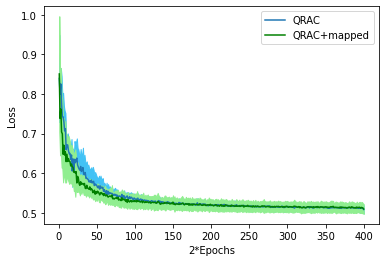

In [29]:
mean_epoch = np.mean(np.array(hist_qrac['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

mean_epoch = np.mean(np.array(hist_qrac_mapped['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac_mapped['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC+mapped', color='g')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#90ee90')

# mean_epoch = np.mean(np.array(hist_qrac_vqc['loss_logs']), axis=0)[-400:]
# std_epoch = np.std(np.array(hist_qrac_vqc['loss_logs']), axis=0)[-400:]

# X = np.arange(1,401)
# plt.plot(X, mean_epoch, label='QRAC+VQC', color='r')
# plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

plt.xlabel('2*Epochs')
plt.ylabel('Loss')

plt.legend()

In [31]:
np.array(hist_qrac_mapped['loss_logs'])[:,-1]

array([0.49996849, 0.52890141, 0.49476143, 0.51983825, 0.50751574])

In [32]:
np.array(hist_qrac['loss_logs'])[:,-1]

array([0.50638804, 0.52304691, 0.49223289, 0.5111323 , 0.51109943])

In [44]:
model_name = 'models/titanic_QRAC_mapped_implementation_fold_0.npz'
feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
var_form = variational_forms.RYRZ(num_qubit, depth=4)

qsvm = VQC(SPSA(0), feature_map, var_form, training_input)
backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
qsvm.run(quantum_instance)
qsvm.load_model(model_name)
y_pred = qsvm.predict(data_train)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  """
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algo

In [48]:
np.mean(y_pred[1] == y)

0.7968574635241302

In [56]:
import glob

results = []

for model_name in glob.glob('models/titanic_QRAC_mapped_implementation_fold_*.npz'):
    feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
    var_form = variational_forms.RYRZ(num_qubit, depth=4)
    qsvm = VQC(SPSA(0), feature_map, var_form, training_input)
    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)

    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
    qsvm.run(quantum_instance)
    qsvm.load_model(model_name)
    results.append(qsvm.predict(data_test))

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  import sys
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.compo

2020-08-11 14:54:48,104:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-11 14:54:48,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-11 14:54:48,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-11 14:54:48,106:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 1
2020-08-11 14:55:06,105:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 14:55:08,800:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7089651276040971
2020-08-11 14:55:26,684:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 14:55:29,310:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.853684607748178
2020-08-11 14:55:29,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA par

2020-08-11 14:57:12,915:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-11 14:57:12,915:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-11 14:57:12,916:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-11 14:57:12,917:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 1
2020-08-11 14:57:30,967:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 14:57:33,993:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6722230328207464
2020-08-11 14:57:51,386:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 14:57:54,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7240608275953966
2020-08-11 14:57:54,063:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA pa

In [57]:
results

[(array([[0.81933594, 0.18066406],
         [0.47070312, 0.52929688],
         [0.72070312, 0.27929688],
         [0.83691406, 0.16308594],
         [0.34277344, 0.65722656],
         [0.74804688, 0.25195312],
         [0.38769531, 0.61230469],
         [0.62988281, 0.37011719],
         [0.390625  , 0.609375  ],
         [0.82519531, 0.17480469],
         [0.85351562, 0.14648438],
         [0.63671875, 0.36328125],
         [0.14648438, 0.85351562],
         [0.6328125 , 0.3671875 ],
         [0.40722656, 0.59277344],
         [0.22558594, 0.77441406],
         [0.72363281, 0.27636719],
         [0.84375   , 0.15625   ],
         [0.39941406, 0.60058594],
         [0.43945312, 0.56054688],
         [0.59765625, 0.40234375],
         [0.76660156, 0.23339844],
         [0.21191406, 0.78808594],
         [0.67382812, 0.32617188],
         [0.40527344, 0.59472656],
         [0.58007812, 0.41992188],
         [0.13183594, 0.86816406],
         [0.83105469, 0.16894531],
         [0.42675781

In [58]:
av_submission = []
majority_vote = []

for result in results:
    pred_av, pred_maj = np.round(results[0][0][:,1]).astype(np.float32), results[0][1].astype(np.float32)
    av_submission.append(pred_av)
    majority_vote.append(pred_maj)
    
av_submission = np.round(np.mean(av_submission, axis=0)).astype(np.int32)
majority_vote = np.round(np.mean(majority_vote, axis=0)).astype(np.int32)

In [61]:
av_submission - majority_vote

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

# prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(av_submission, 'av_mapped_submission.csv')

# Original 3-1 Encoder with mapper no augment (bad result)

In [62]:
df_train, df_test, y_train, _ = load_titanic_pd('train.csv', 'test.csv')

/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = numer_map[df[col][i]]
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = value
/home/hpc/Desktop/Napat_work/qc_group_project/data_provider.py:131: SettingWithCopyWarning

     Survived  Pclass Sex Age  SibSp  Parch  Fare Embarked
0           0       3   0   2      1      0     0        0
1           1       1   1   3      1      0     3        1
2           1       3   1   2      0      0     0        0
3           1       1   1   3      1      0     3        0
4           0       3   0   3      0      0     0        0
..        ...     ...  ..  ..    ...    ...   ...      ...
886         0       2   0   2      0      0     1        0
887         1       1   1   1      0      0     3        0
888         0       3   1   3      1      2     2        0
889         1       1   0   2      0      0     3        1
890         0       3   0   3      0      0     0        2

[891 rows x 8 columns]


In [63]:
from quantum_utils import select_features
mvp_col = select_features(df_train, y_train, feat_num=4)

-----
Full features:
Final train score: 0.893378
Final F1 score: 0.854962
-----
Majority
Final train acc: 0.616162
Final train F1:0.000000
Feature rank based on importance
['Sex', 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Embarked']
Selected features: Sex,Age,Fare,Pclass


In [64]:
df_train, df_test = df_train[mvp_col], df_test[mvp_col]

In [65]:
df_q = df_train[mvp_col]

data = []

bit_each_col = []

# Check number of different category in df_all
for col in df_q.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_q[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_q.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    data.append(all_b_st)

data_train = np.array(data)



In [66]:
df_q = df_test[mvp_col]
data = []
for row in df_q.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    data.append(all_b_st)

data_test = np.array(data)

In [67]:
df = pd.DataFrame(data={
    'input_s': data_train
})

df['f1'] = df.input_s.str[:3]
df['f2'] = df.input_s.str[3:6]
df['f3'] = df.input_s.str[6:9]

df['y'] = y


In [68]:
sym_list = ['000','001','010','011','100','101','110','111']

q_columns = ['f1', 'f2', 'f3']

q_map = []

for cl in q_columns:
    sort_symbol = df[[cl,'y']].groupby(cl).mean().sort_values('y')
    neg = sort_symbol[sort_symbol.y < 0.5]
    pos = sort_symbol[sort_symbol.y >= 0.5]
    
    q_mapper = {}
    pos_sym = 0
    for idx in pos.index:
        q_mapper[idx] = sym_list[pos_sym]
        pos_sym += 1
        
    neg_sym = -1
    for idx in neg.index:
        q_mapper[idx] = sym_list[neg_sym]
        neg_sym -= 1
        
    print(sort_symbol)
        
    q_map.append(q_mapper)

q_map

            y
f1           
011  0.136364
001  0.168865
010  0.183908
000  0.292135
100  0.706667
101  0.745946
110  0.760000
111  1.000000
            y
f2           
000  0.194030
100  0.202970
101  0.361702
110  0.422535
010  0.430769
001  0.494118
011  0.556604
111  0.611940
            y
f3           
110  0.242363
100  0.472826
010  0.629630


[{'100': '000',
  '101': '001',
  '110': '010',
  '111': '011',
  '011': '111',
  '001': '110',
  '010': '101',
  '000': '100'},
 {'011': '000',
  '111': '001',
  '000': '111',
  '100': '110',
  '101': '101',
  '110': '100',
  '010': '011',
  '001': '010'},
 {'010': '000', '110': '111', '100': '110'}]

In [70]:
np.mean(y)

0.3838383838383838

In [71]:
from sklearn.model_selection import KFold
from quantum_utils import CustomFeatureMap

np.random.seed(123123)

kf = KFold(5, shuffle=True)

loss_logs_31 = []
results_31 = []
acc_f1s_train_31 = []
acc_f1s_test_31 = []

def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)
        
    feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
    var_form = variational_forms.RYRZ(num_qubit, depth=4)

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/titanic_QRAC_mapped_no13_implementation_fold_{ro}')

    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_train)):
    
    
    df_train_q, y_train = data_train[train_idxs], y[train_idxs]
    df_test_q, y_test = data_train[test_idxs], y[test_idxs]
    
    # No augment
    training_input = {
        0: df_train_q[y_train == 0],
        1: df_train_q[y_train == 1]
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31.append(loss_log)
    results_31.append(result)
    acc_f1s_train_31.append(acc_f1_train)
    acc_f1s_test_31.append(acc_f1_test)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.components.feature_

2020-08-11 16:04:34,156:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:04:36,595:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8315769770446607
2020-08-11 16:04:52,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:04:55,111:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8429619056516772
2020-08-11 16:04:55,112:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 10 of 25
2020-08-11 16:05:11,047:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:05:13,495:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8207193392962948
2020-08-11 16:05:29,348:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:05:31,735:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.804

2020-08-11 16:14:43,376:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.9020835
2020-08-11 16:14:59,258:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:15:01,623:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5619401569054946
2020-08-11 16:15:17,389:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:15:20,081:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5876838265489447
2020-08-11 16:15:20,081:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.5619402
2020-08-11 16:15:20,082:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.5876838
2020-08-11 16:15:36,023:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:15:38,388:qiskit.aqua.algorithms.classifiers

2020-08-11 16:22:06,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5499051061121544
2020-08-11 16:22:06,348:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.5314452
2020-08-11 16:22:06,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.5499051
2020-08-11 16:22:21,982:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:22:24,377:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5294509166193543
2020-08-11 16:22:40,398:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:22:42,772:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5348343616746956
2020-08-11 16:22:42,773:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.5294509
2020-08-11 16:22:42,774:qiskit.aqua.components.optimizer

2020-08-11 16:29:09,960:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5099051395486347
2020-08-11 16:29:25,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:29:28,242:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5198017644622378
2020-08-11 16:29:28,243:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 24: 0.5099051
2020-08-11 16:29:28,243:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: 0.5198018
2020-08-11 16:29:44,168:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:29:46,536:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5096912993940496
2020-08-11 16:30:02,626:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:30:05,345:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 16:36:15,901:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.5039941
2020-08-11 16:36:31,562:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:36:33,894:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5046091481114632
2020-08-11 16:36:50,133:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:36:52,932:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.504621261076479
2020-08-11 16:36:52,933:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.5046091
2020-08-11 16:36:52,934:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.5046213
2020-08-11 16:37:08,763:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:37:11,199:qiskit.aqua.algorithms.classifie

2020-08-11 16:43:40,345:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.500375616024921
2020-08-11 16:43:40,346:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.4996647
2020-08-11 16:43:40,346:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.5003756
2020-08-11 16:43:56,024:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:43:58,405:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.498454710939366
2020-08-11 16:44:14,626:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:44:17,404:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5041383491083924
2020-08-11 16:44:17,405:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: 0.4984547
2020-08-11 16:44:17,405:qiskit.aqua.components.optimizers.

2020-08-11 16:50:45,434:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5002575672589827
2020-08-11 16:51:01,664:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:51:04,433:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4973013173118125
2020-08-11 16:51:04,434:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 59: 0.5002576
2020-08-11 16:51:04,434:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 59: 0.4973013
2020-08-11 16:51:20,211:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:51:22,577:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.500494880076149
2020-08-11 16:51:38,819:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:51:41,587:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-08-11 16:57:51,520:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.4969654
2020-08-11 16:58:07,411:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:58:09,788:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4952646804150707
2020-08-11 16:58:25,894:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:58:28,609:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49762833934035017
2020-08-11 16:58:28,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 71: 0.4952647
2020-08-11 16:58:28,611:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 71: 0.4976283
2020-08-11 16:58:44,654:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 16:58:47,015:qiskit.aqua.algorithms.classif

2020-08-11 17:05:16,180:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49991797673165084
2020-08-11 17:05:16,181:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.4907446
2020-08-11 17:05:16,181:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.4999180
2020-08-11 17:05:31,942:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:05:34,402:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5004364074494946
2020-08-11 17:05:50,549:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:05:53,289:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4970741801066226
2020-08-11 17:05:53,290:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 83: 0.5004364
2020-08-11 17:05:53,290:qiskit.aqua.components.optimize

2020-08-11 17:12:22,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49486364363722235
2020-08-11 17:12:38,197:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:12:41,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49173794577676666
2020-08-11 17:12:41,004:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 94: 0.4948636
2020-08-11 17:12:41,005:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 94: 0.4917379
2020-08-11 17:12:56,752:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:12:59,119:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4881802533192019
2020-08-11 17:13:15,376:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:13:18,091:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 17:19:26,818:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.4901277
2020-08-11 17:19:42,832:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:19:45,507:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4939322911961758
2020-08-11 17:20:01,244:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:20:03,603:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4887525414345282
2020-08-11 17:20:03,604:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 106: 0.4939323
2020-08-11 17:20:03,605:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 106: 0.4887525
2020-08-11 17:20:19,841:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:20:22,560:qiskit.aqua.algorithms.class

2020-08-11 17:26:51,291:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4891368518563304
2020-08-11 17:26:51,292:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.4935702
2020-08-11 17:26:51,293:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.4891369
2020-08-11 17:27:07,489:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:27:10,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4919527490385198
2020-08-11 17:27:26,143:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:27:28,490:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4880799367596283
2020-08-11 17:27:28,491:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 118: 0.4919527
2020-08-11 17:27:28,492:qiskit.aqua.components.optimi

2020-08-11 17:33:57,366:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49256651878887775
2020-08-11 17:34:13,159:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:34:15,582:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4924570819388709
2020-08-11 17:34:15,582:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 129: 0.4925665
2020-08-11 17:34:15,582:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 129: 0.4924571
2020-08-11 17:34:31,723:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:34:34,476:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.492158575068139
2020-08-11 17:34:50,463:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:34:52,829:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 17:42:36,253:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.491678307242461
2020-08-11 17:42:51,920:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:42:54,247:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4928144872767631
2020-08-11 17:42:54,248:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 143: 0.4916783
2020-08-11 17:42:54,249:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 143: 0.4928145
2020-08-11 17:43:10,254:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:43:12,953:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49206946557451753
2020-08-11 17:43:28,779:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:43:31,107:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 17:49:42,888:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 154: 0.4888337
2020-08-11 17:49:59,150:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:50:01,945:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4899345384260642
2020-08-11 17:50:17,825:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:50:20,190:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4909332635478371
2020-08-11 17:50:20,191:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 155: 0.4899345
2020-08-11 17:50:20,191:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 155: 0.4909333
2020-08-11 17:50:36,519:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:50:39,278:qiskit.aqua.algorithms.class

2020-08-11 17:57:07,478:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4862071012168862
2020-08-11 17:57:07,479:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 166: 0.4891194
2020-08-11 17:57:07,480:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 166: 0.4862071
2020-08-11 17:57:23,556:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:57:26,267:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48931830930470205
2020-08-11 17:57:41,962:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 17:57:44,361:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48661784923952794
2020-08-11 17:57:44,362:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 167: 0.4893183
2020-08-11 17:57:44,362:qiskit.aqua.components.opti

2020-08-11 18:04:13,809:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4912422873248833
2020-08-11 18:04:29,705:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:04:32,076:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48937176253509995
2020-08-11 18:04:32,077:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 178: 0.4912423
2020-08-11 18:04:32,078:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 178: 0.4893718
2020-08-11 18:04:48,188:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:04:50,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48770551395036343
2020-08-11 18:05:06,874:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:05:09,348:qiskit.aqua.algorithms.classifiers.vq

2020-08-11 18:11:19,971:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 189: 0.4878923
2020-08-11 18:11:36,478:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:11:39,260:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4906308309167421
2020-08-11 18:11:55,175:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:11:57,566:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48884143305176164
2020-08-11 18:11:57,566:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 190: 0.4906308
2020-08-11 18:11:57,567:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 190: 0.4888414
2020-08-11 18:12:13,714:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:12:16,569:qiskit.aqua.algorithms.clas

2020-08-11 18:17:54,458:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-08-11 18:18:10,609:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.components.feature_maps.FeatureMap object is deprecated as of 0.7.0 and will be removed no earlier than 3 months after the release. You should pass a QuantumCircuit object instead. See also qiskit.circuit.library.data_preparation for a collection of suitable circuits.
  self.feature_map = feature_map
2020-08-11 18:18:13,033:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.2
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 

2020-08-11 18:24:37,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:24:39,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.2108549938757507
2020-08-11 18:24:55,334:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:24:57,715:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.130489838005879
2020-08-11 18:25:13,917:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:25:16,652:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.0054213814192177
2020-08-11 18:25:32,460:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:25:34,921:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 1.2935712702964544
2020-08-11 18:25:50,696:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validati

2020-08-11 18:34:47,364:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6830547035957137
2020-08-11 18:34:47,365:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.7124704
2020-08-11 18:34:47,366:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.6830547
2020-08-11 18:35:03,539:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:35:05,899:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7250655215867147
2020-08-11 18:35:22,054:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:35:24,466:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6607053988397434
2020-08-11 18:35:24,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: 0.7250655
2020-08-11 18:35:24,468:qiskit.aqua.components.optimizers.s

2020-08-11 18:41:52,295:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5458938527065571
2020-08-11 18:42:08,450:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:42:11,188:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5274036581625694
2020-08-11 18:42:11,189:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.5458939
2020-08-11 18:42:11,189:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 13: 0.5274037
2020-08-11 18:42:26,961:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:42:29,349:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.530149380504618
2020-08-11 18:42:45,025:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:42:47,394:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-08-11 18:48:56,658:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: 0.5165484
2020-08-11 18:49:12,751:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:49:15,204:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5198708717749367
2020-08-11 18:49:30,963:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:49:33,797:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5313528590428861
2020-08-11 18:49:33,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 25: 0.5198709
2020-08-11 18:49:33,799:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 25: 0.5313529
2020-08-11 18:49:49,491:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:49:51,912:qiskit.aqua.algorithms.classifi

2020-08-11 18:56:19,070:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5161041729831172
2020-08-11 18:56:19,071:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.5131543
2020-08-11 18:56:19,071:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.5161042
2020-08-11 18:56:35,232:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:56:37,592:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5151312510100543
2020-08-11 18:56:53,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 18:56:55,971:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.514411828393767
2020-08-11 18:56:55,972:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 37: 0.5151313
2020-08-11 18:56:55,973:qiskit.aqua.components.optimizers

2020-08-11 19:03:23,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5149286826381542
2020-08-11 19:03:39,409:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:03:41,787:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5154864732180857
2020-08-11 19:03:41,788:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: 0.5149287
2020-08-11 19:03:41,789:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 48: 0.5154865
2020-08-11 19:03:58,118:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:04:00,447:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5124298569737303
2020-08-11 19:04:16,681:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:04:19,083:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 19:10:27,217:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 59: 0.5147976
2020-08-11 19:10:43,004:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:10:45,769:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5104438340510877
2020-08-11 19:11:01,688:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:11:04,047:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5133269810888941
2020-08-11 19:11:04,048:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 60: 0.5104438
2020-08-11 19:11:04,049:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 60: 0.5133270
2020-08-11 19:11:19,737:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:11:22,431:qiskit.aqua.algorithms.classifi

2020-08-11 19:17:49,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5123015823461391
2020-08-11 19:17:49,492:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 71: 0.5150870
2020-08-11 19:17:49,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 71: 0.5123016
2020-08-11 19:18:05,564:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:18:07,933:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5116445379684319
2020-08-11 19:18:23,723:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:18:26,419:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5160996524596698
2020-08-11 19:18:26,420:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 72: 0.5116445
2020-08-11 19:18:26,421:qiskit.aqua.components.optimizer

2020-08-11 19:24:52,839:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5140165809798791
2020-08-11 19:25:09,101:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:25:11,480:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5140602620862973
2020-08-11 19:25:11,481:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 83: 0.5140166
2020-08-11 19:25:11,481:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 83: 0.5140603
2020-08-11 19:25:27,435:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:25:29,819:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5093719918388018
2020-08-11 19:25:46,256:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:25:48,598:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-11 19:31:58,997:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 94: 0.5053938
2020-08-11 19:32:15,241:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:32:17,633:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5105374392274703
2020-08-11 19:32:33,820:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:32:36,241:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5103562312842724
2020-08-11 19:32:36,242:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 95: 0.5105374
2020-08-11 19:32:36,242:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 95: 0.5103562
2020-08-11 19:32:52,268:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:32:55,078:qiskit.aqua.algorithms.classifi

2020-08-11 19:39:22,723:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.513424453118102
2020-08-11 19:39:22,724:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 106: 0.5071453
2020-08-11 19:39:22,725:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 106: 0.5134245
2020-08-11 19:39:38,566:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:39:40,996:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5038412024153223
2020-08-11 19:39:57,069:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:39:59,447:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.514543787291776
2020-08-11 19:39:59,448:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 107: 0.5038412
2020-08-11 19:39:59,449:qiskit.aqua.components.optimize

2020-08-11 19:46:25,977:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5111558738409276
2020-08-11 19:46:42,225:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:46:44,604:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5109279880092749
2020-08-11 19:46:44,605:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 118: 0.5111559
2020-08-11 19:46:44,606:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 118: 0.5109280
2020-08-11 19:47:00,481:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:47:02,993:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5097570058104255
2020-08-11 19:47:18,676:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:47:21,376:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 19:53:28,477:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 129: 0.5097919
2020-08-11 19:53:44,043:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:53:46,451:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.511939826059106
2020-08-11 19:54:02,789:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:54:05,195:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.510178013221908
2020-08-11 19:54:05,196:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 130: 0.5119398
2020-08-11 19:54:05,197:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 130: 0.5101780
2020-08-11 19:54:21,241:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 19:54:23,655:qiskit.aqua.algorithms.classif

2020-08-11 20:00:52,510:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5094482584277452
2020-08-11 20:00:52,511:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 141: 0.5137389
2020-08-11 20:00:52,512:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 141: 0.5094483
2020-08-11 20:01:08,507:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:01:10,937:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5066195747066092
2020-08-11 20:01:26,995:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:01:29,313:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.509942190272397
2020-08-11 20:01:29,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 142: 0.5066196
2020-08-11 20:01:29,314:qiskit.aqua.components.optimiz

2020-08-11 20:07:57,263:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5054431283819878
2020-08-11 20:08:13,255:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:08:15,957:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5092470047404545
2020-08-11 20:08:15,958:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 153: 0.5054431
2020-08-11 20:08:15,958:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 153: 0.5092470
2020-08-11 20:08:31,634:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:08:34,031:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5060261607438848
2020-08-11 20:08:49,736:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:08:52,134:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 20:15:00,527:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 164: 0.5075462
2020-08-11 20:15:16,617:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:15:19,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.507937028945361
2020-08-11 20:15:35,028:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:15:37,754:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5141161106648089
2020-08-11 20:15:37,755:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 165: 0.5079370
2020-08-11 20:15:37,756:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 165: 0.5141161
2020-08-11 20:15:53,575:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:15:55,908:qiskit.aqua.algorithms.classi

2020-08-11 20:22:23,676:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5083840239334845
2020-08-11 20:22:23,677:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 176: 0.5077508
2020-08-11 20:22:23,678:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 176: 0.5083840
2020-08-11 20:22:39,653:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:22:42,038:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5048080085137014
2020-08-11 20:22:57,983:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:23:00,370:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5062566084664484
2020-08-11 20:23:00,371:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: 0.5048080
2020-08-11 20:23:00,372:qiskit.aqua.components.optimi

2020-08-11 20:29:28,561:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5075764611476362
2020-08-11 20:29:44,688:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:29:47,082:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5053567207615416
2020-08-11 20:29:47,083:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 188: 0.5075765
2020-08-11 20:29:47,083:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 188: 0.5053567
2020-08-11 20:30:03,093:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:30:05,515:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5019541413899868
2020-08-11 20:30:21,445:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:30:23,877:qiskit.aqua.algorithms.classifiers.vqc:

2020-08-11 20:36:34,643:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 199: 0.4997303
2020-08-11 20:36:50,570:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:36:52,968:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5014144124292457
2020-08-11 20:36:52,969:qiskit.aqua.components.optimizers.spsa:DEBUG: Final objective function is: 0.5014144
2020-08-11 20:36:52,970:qiskit.aqua.algorithms.classifiers.vqc:INFO: Optimization complete in 8319.935885190964 seconds.
Found opt_params [ 0.80921255 -0.36842636 -1.95440204 -0.08159266 -0.73721084  1.64042318
  1.08946981 -0.25695978 -1.40714797 -0.50449389 -2.21571938  0.08730302
 -0.52131556 -1.24271943 -0.34699265 -2.59091456  0.35133729  0.67106886
 -0.49075377 -1.19990131 -0.13109351  0.54283187 -1.166096    0.34319653
  3.06708052  1.00974553  1.70714547 -1.39911595 -1.1841052   1.20758702] in 451 evals
2020-08-11 20:36:52,

2020-08-11 20:42:11,099:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.718792389853131
2020-08-11 20:42:27,184:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:42:29,591:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7257111224930183
2020-08-11 20:42:45,643:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:42:48,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7577508032369934
2020-08-11 20:43:04,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:43:06,479:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7768203029627168
2020-08-11 20:43:22,644:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:43:25,364:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate ba

2020-08-11 20:52:52,545:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:52:55,248:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7475509556581753
2020-08-11 20:53:11,044:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:53:13,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7335378985416399
2020-08-11 20:53:13,509:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7475510
2020-08-11 20:53:13,510:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.7335379
2020-08-11 20:53:29,287:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 20:53:31,996:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7735428464475819
2020-08-11 20:53:47,708:qiskit.aqua.utils.run_circuits:INFO: Can't 

2020-08-11 20:59:58,506:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.5881217
2020-08-11 20:59:58,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.6493710
2020-08-11 21:00:14,713:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:00:17,090:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6221406975833761
2020-08-11 21:00:33,034:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:00:35,500:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5821357128227134
2020-08-11 21:00:35,501:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.6221407
2020-08-11 21:00:35,501:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.5821357
2020-08-11 21:00:51,728:qiskit.aqua.utils.run_

2020-08-11 21:07:19,533:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:07:21,938:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5717592529803631
2020-08-11 21:07:21,939:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: 0.5412204
2020-08-11 21:07:21,939:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: 0.5717593
2020-08-11 21:07:38,089:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:07:40,466:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5409508900578791
2020-08-11 21:07:56,371:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:07:58,740:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5519636920563474
2020-08-11 21:07:58,741:qiskit.aqua.components.optimizers.spsa:DE

2020-08-11 21:14:23,562:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:14:26,111:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5256876437679363
2020-08-11 21:14:42,509:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:14:44,916:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5367614295746418
2020-08-11 21:14:44,917:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.5256876
2020-08-11 21:14:44,917:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.5367614
2020-08-11 21:15:01,107:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:15:03,516:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.542401885043993
2020-08-11 21:15:19,476:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-11 21:21:32,238:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.5106281
2020-08-11 21:21:32,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.5090660
2020-08-11 21:21:48,304:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:21:50,696:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.513937466414826
2020-08-11 21:22:06,671:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:22:09,073:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5086998036616398
2020-08-11 21:22:09,073:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.5139375
2020-08-11 21:22:09,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.5086998
2020-08-11 21:22:25,270:qiskit.aqua.utils.run_c

2020-08-11 21:28:53,949:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:28:56,271:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5082722049927358
2020-08-11 21:28:56,271:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: 0.5056850
2020-08-11 21:28:56,272:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.5082722
2020-08-11 21:29:12,309:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:29:15,012:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5052529614175263
2020-08-11 21:29:30,719:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:29:33,189:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49834139330605637
2020-08-11 21:29:33,190:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 21:35:58,216:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:36:00,923:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5023360563219573
2020-08-11 21:36:16,528:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:36:18,887:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.502806579068525
2020-08-11 21:36:18,888:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.5023361
2020-08-11 21:36:18,888:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.5028066
2020-08-11 21:36:35,088:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:36:37,561:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5068732966198887
2020-08-11 21:36:53,561:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-08-11 21:43:04,708:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.4942799
2020-08-11 21:43:04,709:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.4990054
2020-08-11 21:43:20,332:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:43:22,742:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4967852582827553
2020-08-11 21:43:38,879:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:43:41,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49722593060188347
2020-08-11 21:43:41,271:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.4967853
2020-08-11 21:43:41,272:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.4972259
2020-08-11 21:43:57,413:qiskit.aqua.utils.run

2020-08-11 21:50:24,592:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:50:26,971:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4962979216711521
2020-08-11 21:50:26,972:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: 0.4952043
2020-08-11 21:50:26,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.4962979
2020-08-11 21:50:42,726:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:50:45,445:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49303086834927007
2020-08-11 21:51:01,051:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:51:03,422:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5003158007676233
2020-08-11 21:51:03,423:qiskit.aqua.components.optimizers.spsa:D

2020-08-11 21:57:30,511:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:57:32,967:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4938764015882857
2020-08-11 21:57:48,640:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:57:51,337:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4971937663788357
2020-08-11 21:57:51,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.4938764
2020-08-11 21:57:51,339:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.4971938
2020-08-11 21:58:07,082:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 21:58:09,487:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49429429505457984
2020-08-11 21:58:25,584:qiskit.aqua.utils.run_circuits:INFO: C

2020-08-11 22:04:37,822:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.4954905
2020-08-11 22:04:37,823:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 116: 0.4972689
2020-08-11 22:04:53,814:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:04:56,227:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4923478514034982
2020-08-11 22:05:12,523:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:05:15,280:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4956293867235141
2020-08-11 22:05:15,281:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.4923479
2020-08-11 22:05:15,281:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.4956294
2020-08-11 22:05:31,144:qiskit.aqua.utils.

2020-08-11 22:11:59,155:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:12:01,542:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49185449677589593
2020-08-11 22:12:01,543:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: 0.4909695
2020-08-11 22:12:01,544:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 0.4918545
2020-08-11 22:12:17,489:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:12:19,859:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49174533833140965
2020-08-11 22:12:35,615:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:12:38,332:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4938062698578229
2020-08-11 22:12:38,333:qiskit.aqua.components.optimizers.sps

2020-08-11 22:19:04,648:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:19:06,982:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49208507096584037
2020-08-11 22:19:23,008:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:19:25,386:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49598830127701765
2020-08-11 22:19:25,387:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 140: 0.4920851
2020-08-11 22:19:25,388:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 140: 0.4959883
2020-08-11 22:19:41,373:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:19:43,770:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49158390462637713
2020-08-11 22:19:59,773:qiskit.aqua.utils.run_circuits:INFO:

2020-08-11 22:26:12,773:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.4879722
2020-08-11 22:26:12,774:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 151: 0.4934291
2020-08-11 22:26:28,772:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:26:31,168:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4878299019653407
2020-08-11 22:26:47,307:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:26:49,667:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49251052280998814
2020-08-11 22:26:49,668:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 152: 0.4878299
2020-08-11 22:26:49,669:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 152: 0.4925105
2020-08-11 22:27:05,525:qiskit.aqua.utils

2020-08-11 22:33:32,973:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:33:35,324:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48952897436563925
2020-08-11 22:33:35,325:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: 0.4900331
2020-08-11 22:33:35,326:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 0.4895290
2020-08-11 22:33:50,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:33:53,711:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4927032912740403
2020-08-11 22:34:09,430:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:34:11,817:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.490069448671914
2020-08-11 22:34:11,818:qiskit.aqua.components.optimizers.spsa:

2020-08-11 22:40:37,449:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:40:39,850:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49015636987851147
2020-08-11 22:40:55,954:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:40:58,349:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4903995974954969
2020-08-11 22:40:58,350:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: 0.4901564
2020-08-11 22:40:58,350:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: 0.4903996
2020-08-11 22:41:14,765:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:41:17,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4884854879993728
2020-08-11 22:41:32,765:qiskit.aqua.utils.run_circuits:INFO: C

2020-08-11 22:47:45,238:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.4945186
2020-08-11 22:47:45,238:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 186: 0.4912107
2020-08-11 22:48:01,469:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:48:03,906:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48919247517469056
2020-08-11 22:48:19,884:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-11 22:48:22,337:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49205957381246374
2020-08-11 22:48:22,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 187: 0.4891925
2020-08-11 22:48:22,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 187: 0.4920596
2020-08-11 22:48:38,720:qiskit.aqua.util

In [72]:
1

1

In [74]:
import pickle

qrac_record = {
    'loss_logs': loss_logs_31,
    'result': results_31,
    'acc_f1s_train': acc_f1s_train_31,
    'acc_f1s_test': acc_f1s_test_31
}

with open('results/titanic_qrac_mapped_no_augment_record.pk', 'wb') as f:
    pickle.dump(qrac_record, f)

In [73]:
np.mean(acc_f1s_train_31, axis=0), np.mean(acc_f1s_test_31, axis=0)

(array([0.763192  , 0.67898471]), array([0.76090641, 0.66638675]))

In [75]:
import pickle 

with open('results/titanic_qrac_record.pk', 'rb') as f:
    hist_qrac = pickle.load(f)
    
with open('results/titanic_qrac_mapped_record.pk', 'rb') as f:
    hist_qrac_mapped = pickle.load(f)
    
with open('results/titanic_qrac_mapped_no_augment_record.pk', 'rb') as f:
    hist_qrac_mapped_no_augment = pickle.load(f)
    
with open('results/titanic_qrac_vqc_record.pk', 'rb') as f:
    hist_qrac_vqc = pickle.load(f)

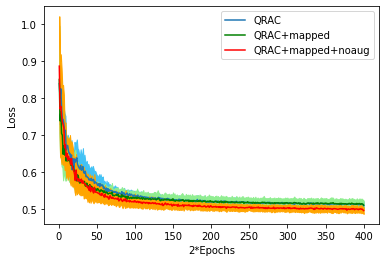

In [77]:
mean_epoch = np.mean(np.array(hist_qrac['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

mean_epoch = np.mean(np.array(hist_qrac_mapped['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac_mapped['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC+mapped', color='g')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#90ee90')

mean_epoch = np.mean(np.array(hist_qrac_mapped_no_augment['loss_logs']), axis=0)[-400:]
std_epoch = np.std(np.array(hist_qrac_mapped_no_augment['loss_logs']), axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC+mapped+noaug', color='r')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

# mean_epoch = np.mean(np.array(hist_qrac_vqc['loss_logs']), axis=0)[-400:]
# std_epoch = np.std(np.array(hist_qrac_vqc['loss_logs']), axis=0)[-400:]

# X = np.arange(1,401)
# plt.plot(X, mean_epoch, label='QRAC+VQC', color='r')
# plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

plt.xlabel('2*Epochs')
plt.ylabel('Loss')

plt.legend()

In [31]:
np.array(hist_qrac_mapped['loss_logs'])[:,-1]

array([0.49996849, 0.52890141, 0.49476143, 0.51983825, 0.50751574])

In [32]:
np.array(hist_qrac['loss_logs'])[:,-1]

array([0.50638804, 0.52304691, 0.49223289, 0.5111323 , 0.51109943])

In [44]:
model_name = 'models/titanic_QRAC_mapped_implementation_fold_0.npz'
feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
var_form = variational_forms.RYRZ(num_qubit, depth=4)

qsvm = VQC(SPSA(0), feature_map, var_form, training_input)
backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
qsvm.run(quantum_instance)
qsvm.load_model(model_name)
y_pred = qsvm.predict(data_train)

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  """
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algo

In [48]:
np.mean(y_pred[1] == y)

0.7968574635241302

In [78]:
import glob

results = []

for model_name in glob.glob('models/titanic_QRAC_mapped_no13_implementation_fold_*.npz'):
    feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit, q_map)
    var_form = variational_forms.RYRZ(num_qubit, depth=4)
    qsvm = VQC(SPSA(0), feature_map, var_form, training_input)
    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)

    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=0, seed_transpiler=0,optimization_level=3)
    qsvm.run(quantum_instance)
    qsvm.load_model(model_name)
    results.append(qsvm.predict(data_test))

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  import sys
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.compo

2020-08-12 14:57:29,676:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-12 14:57:29,677:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-12 14:57:29,678:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-12 14:57:29,679:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 1
2020-08-12 14:57:45,793:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-12 14:57:48,253:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8238035882156898
2020-08-12 14:58:04,009:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-12 14:58:06,420:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.858103966381326
2020-08-12 14:58:06,421:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA par

2020-08-12 14:59:42,169:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-08-12 14:59:42,170:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-08-12 14:59:42,171:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-08-12 14:59:42,171:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 1
2020-08-12 14:59:58,123:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-12 15:00:00,572:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6764948923870822
2020-08-12 15:00:16,281:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-12 15:00:18,977:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6178091575580886
2020-08-12 15:00:18,978:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA pa

In [79]:
results

[(array([[0.87402344, 0.12597656],
         [0.6328125 , 0.3671875 ],
         [0.796875  , 0.203125  ],
         [0.8671875 , 0.1328125 ],
         [0.42578125, 0.57421875],
         [0.81054688, 0.18945312],
         [0.31542969, 0.68457031],
         [0.765625  , 0.234375  ],
         [0.4296875 , 0.5703125 ],
         [0.67089844, 0.32910156],
         [0.87207031, 0.12792969],
         [0.62207031, 0.37792969],
         [0.13671875, 0.86328125],
         [0.765625  , 0.234375  ],
         [0.29785156, 0.70214844],
         [0.56933594, 0.43066406],
         [0.81640625, 0.18359375],
         [0.86328125, 0.13671875],
         [0.51660156, 0.48339844],
         [0.66796875, 0.33203125],
         [0.50878906, 0.49121094],
         [0.72753906, 0.27246094],
         [0.11914062, 0.88085938],
         [0.50292969, 0.49707031],
         [0.29589844, 0.70410156],
         [0.71875   , 0.28125   ],
         [0.15039062, 0.84960938],
         [0.86132812, 0.13867188],
         [0.33203125

In [80]:
av_submission = []
majority_vote = []

for result in results:
    pred_av, pred_maj = np.round(results[0][0][:,1]).astype(np.float32), results[0][1].astype(np.float32)
    av_submission.append(pred_av)
    majority_vote.append(pred_maj)
    
av_submission = np.round(np.mean(av_submission, axis=0)).astype(np.int32)
majority_vote = np.round(np.mean(majority_vote, axis=0)).astype(np.int32)

In [81]:
av_submission - majority_vote

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [82]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

# prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(av_submission, 'av_mapped_noaug_submission.csv')